<a href="https://colab.research.google.com/github/harrisb002/Hyperspectral-Landcover-Classification/blob/main/CombinedCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# (Used for both 1D & 2D)

### Imports, Filepaths, & Mount Drive

In [129]:
!pip install gdal
!pip install rasterio
!pip install raster2xyz
!pip install matplotlib
!pip install scikit-learn
!pip install seaborn
!pip install tensorflow
!pip install tabulate
!pip install scikit-image
!pip install openpyxl
!pip install tifffile
!pip install imagecodecs

In [204]:
# File and directory handling
import os
import shutil
from os import listdir
from os.path import isfile, join

# Data handling and processing
import pandas as pd
import numpy as np
from collections import Counter
import random
import ast
from scipy import stats
from scipy.ndimage import zoom, generic_filter
from skimage.transform import resize
from skimage.morphology import (
    dilation, square, opening, closing, area_opening,
    area_closing, remove_small_objects, remove_small_holes
)

# Image processing
import rasterio
from rasterio.plot import show
from raster2xyz.raster2xyz import Raster2xyz
from tifffile import imread
import cv2

# Data preprocessing and metrics
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.preprocessing import (
    StandardScaler, RobustScaler, LabelEncoder,
    Normalizer
)
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold,
    StratifiedShuffleSplit, GridSearchCV
)
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    classification_report, ConfusionMatrixDisplay
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# CNN
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Input, Dense, Conv1D, Flatten, MaxPooling1D,
    AveragePooling2D, GlobalAveragePooling1D, Dropout,
    BatchNormalization, RandomFlip, Activation
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from tabulate import tabulate

# Enable inline plots for Jupyter notebooks
%matplotlib inline


In [131]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

############## Update your 'mainDir' if your utlizing my code!!! ###############
mainDir = "/content/drive/My Drive/.School/Capstone/"
checkpointDir = "/content/drive/My Drive/.School/Capstone/Checkpoints/"
################################################################################

################################################################################
# Using Shared Directory
# Be careful not to override others Checkpoints! => Make unique to your name
################################################################################
# Example:
# checkpoint_path = mainDir + 'model_checkpoints_{Your_Name_Here}/my_weights.weights.h5'
# mainDir = "/content/drive/Shareddrives/Land_Classification_Training_shared/Land_Classification_training_work/"
################################################################################

# Define file paths
images_path = mainDir + "valid_samples_1d/avirisng_samples_combined"
samples_path = mainDir + "valid_samples_1d/samples.csv"

# DEFINE YOUR MODEL CHECKPOINT
# MODEL CHECKPOINTS, ONLY USE TESTING TRAINING, OTHERWISE USE LOADING

# 1D Checkpoints
################################################################################
checkpoint_path = checkpointDir + 'model_checkpoints_Benz_Testing/my_weights.weights.h5'
best_checkpoint_path = checkpointDir + 'model_checkpoints_Benz/my_weights.weights.h5'
checkpoint_path_class_weights = checkpointDir + 'model_checkpoints_Benz/my_weights_with_cw.weights.h5'
checkpoint_path_class_weights_oversampling = checkpointDir + 'model_checkpoints_Benz/my_weights_with_cw_oversampling.weights.h5'
################################################################################

# 2D Checkpoints
################################################################################
microcnn_checkpoint_path = checkpointDir + 'microcnn_best.weights.h5'
macrocnn_checkpoint_path = checkpointDir + 'macrocnn_best.weights.h5'
rgbcnn_checkpoint_path = checkpointDir + 'rgbcnn_best.weights.h5'
################################################################################

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Loading, Preprocessing, Verification

In [132]:
def preprocess_data(samples_df):
  """
  Preprocess the samples DataFrame:
  1. Extract Sample_num
  2. Clean Labels
  3. Remove rows with 'Mixed or Not Classified'
  4. Replace NaNs and invalid values in frequency columns
  5. Label-encode the labels
  """
  samples_df['Sample_num'] = samples_df['File'].str.split('_').str[0].astype(int)
  samples_df['Label'] = samples_df['Label'].str.split('(').str[0].str.strip()

  # Remove "Mixed or Not Classified"
  samples_df = samples_df[samples_df['Label'] != 'Mixed or Not Classified']
  samples_df.reset_index(drop=True, inplace=True)

  # Handle frequency columns
  frequency_columns = [col for col in samples_df.columns if col.startswith('frq')]
  samples_df.loc[:, frequency_columns] = samples_df[frequency_columns].fillna(-9999)
  samples_df = samples_df[~samples_df[frequency_columns].eq(-9999).any(axis=1)]

  # Verify no invalid values remain
  nan_counts = samples_df[frequency_columns].isna().sum().sum()
  assert nan_counts == 0, "NaN values still exist in frequency columns after replacement"
  count_negative_9999 = (samples_df[frequency_columns] == -9999).sum().sum()
  assert count_negative_9999 == 0, "Rows with -9999 values remain after filtering"

  # Label Encoding
  label_encoder = LabelEncoder()
  samples_df['Label_Encoded'] = label_encoder.fit_transform(samples_df['Label'])

  return samples_df, label_encoder

In [133]:
def combine_classes(samples_df, classes_to_combine, combined_class_name="Shrubs and Natural Grassland"):
  """
  Combines multiple classes into a single class.
  """
  samples_df['Label'] = samples_df['Label'].replace(
      dict.fromkeys(classes_to_combine, combined_class_name)
  )

  remaining_sample_classes = set(samples_df['Label'].unique())

  for c in classes_to_combine:
      if c in remaining_sample_classes:
          raise ValueError(f"Class '{c}' still present after combination.")
  if combined_class_name not in remaining_sample_classes:
      raise ValueError(f"Combined class '{combined_class_name}' not found after combination.")

  print("Classes combined successfully.")
  return samples_df

In [134]:
def remove_wetlands(samples_df):
  # Extract Sample_num from the File column in samples_df
  samples_df['Sample_num'] = samples_df['File'].str.split('_').str[0].astype(int)

  # Identify all Sample_num values associated with "Wetlands" in samples_df
  wetlands_samples = samples_df[samples_df['Label'].str.contains("Wetlands", na=False)]['Sample_num'].unique()

  # Remove rows in samples_df associated with the same Sample_num
  samples_df = samples_df[~samples_df['Sample_num'].isin(wetlands_samples)]

  # Verification
  # Check that no rows with the removed Sample_num values are present in samples_df
  assert not samples_df['Sample_num'].isin(wetlands_samples).any(), "Wetlands samples still present in samples_df."

  print("Successfully removed 'Wetlands' from the dataset.")
  return samples_df

In [135]:
def remove_planted_forest(samples_df):
    # Extract Sample_num from the File column in samples_df
    # (This step ensures that Sample_num is available and consistent)
    samples_df['Sample_num'] = samples_df['File'].str.split('_').str[0].astype(int)

    # Identify all Sample_num values associated with "Planted Forest" in samples_df
    planted_forest_samples = samples_df[samples_df['Label'].str.contains("Planted Forest", na=False)]['Sample_num'].unique()

    # Remove rows in samples_df associated with these Sample_num values
    samples_df = samples_df[~samples_df['Sample_num'].isin(planted_forest_samples)]

    # Verification:
    # Check that no rows with the removed Sample_num values are present in samples_df
    assert not samples_df['Sample_num'].isin(planted_forest_samples).any(), "Planted Forest samples still present in samples_df."

    print("Successfully removed 'Planted Forest' from the dataset.")
    return samples_df

### Training, Callbacks & Evaluation

In [136]:
def train_model(model, X_train, y_train_cat, X_test, y_test_cat, epochs, batch_size, checkpoint_path):
  history = model.fit(X_train,
      y_train_cat,
      validation_data=(X_test, y_test_cat),
      epochs=epochs,
      batch_size=batch_size,
      callbacks=define_callbacks(checkpoint_path)
    )
  return history

In [250]:
def define_callbacks(checkpoint_path):
  # Make sure path ebds with .h5
  assert checkpoint_path.endswith(".h5"), "checkpoint_path should end with '.h5' for ModelCheckpoint."

  early_stopping = EarlyStopping(monitor='val_accuracy',
                                 patience=30,
                                 mode='max',
                                 verbose=1)

  lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                   factor=0.2,
                                   patience=20,
                                   verbose=1,
                                   min_lr=1e-6)

  checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                               save_weights_only=True,
                               monitor='val_accuracy',
                               save_best_only=True,
                               verbose=1)

  return [checkpoint, early_stopping, lr_scheduler]

In [138]:
def evaluate_model(model, X_test, y_test_cat):
  test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=1)
  print(f"Test Accuracy: {test_accuracy:.4f}")
  return test_accuracy

### Class Weights

In [139]:
def get_class_weights(y_train):
  classes = np.unique(y_train)
  weights = class_weight.compute_class_weight('balanced', classes=classes, y=y_train)
  class_weights_dict = dict(enumerate(weights))

  # Sort in desc. order
  sorted_weights = sorted(class_weights_dict.items(), key=lambda item: item[1], reverse=True)

  # Print formatted weights
  print("\nClass Weights:")
  for class_index, weight in sorted_weights:
    # Decode class index to label
    class_label = label_encoder.inverse_transform([class_index])[0]
    print(f"{class_label.ljust(22)} Weight: {str(weight).ljust(10)}")

  return class_weights_dict

In [140]:
def get_adjusted_class_weights(y_true, y_pred, label_encoder):
    # Ensure that label_encoder.classes_ includes all possible classes
    all_classes = np.union1d(np.unique(y_true), np.unique(y_pred))
    missing_classes = set(all_classes) - set(range(len(label_encoder.classes_)))
    if missing_classes:
        raise ValueError(f"Missing classes in label_encoder: {missing_classes}")

    # Compute F1-scores for each class
    f1_scores = f1_score(y_true, y_pred, average=None, labels=np.unique(y_true))
    classes = np.unique(y_true)

    # Map class indices to F1-scores
    class_f1_scores = dict(zip(classes, f1_scores))

    # Invert F1-scores to get weights (add small epsilon to avoid division by zero)
    epsilon = 1e-6
    inverted_f1_scores = {cls: 1 / (score + epsilon) for cls, score in class_f1_scores.items()}

    # Normalize weights to have a mean of 1
    mean_weight = np.mean(list(inverted_f1_scores.values()))
    normalized_weights = {cls: weight / mean_weight for cls, weight in inverted_f1_scores.items()}

    # Map class indices to weights
    class_weights_dict = {cls: normalized_weights[cls] for cls in classes}

    # Print formatted weights
    print("\nAdjusted Class Weights:")
    for class_index in classes:
      # Safely decode class labels
      if class_index >= len(label_encoder.classes_):
          class_label = f"Unknown (Index {class_index})"
      else:
          class_label = label_encoder.inverse_transform([class_index])[0]
      weight = class_weights_dict[class_index]
      print(f"{class_label.ljust(22)} Weight: {weight:.3f}")

    return class_weights_dict

In [141]:
def train_model_with_class_weights(model, X_train, y_train_cat, X_test, y_test_cat, class_weights, epochs=5, batch_size=32):
  history = model.fit(
    X_train,
    y_train_cat,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=define_callbacks(checkpoint_path),
  )
  return history

### Augmentation

In [142]:
def data_generator(X, y, batch_size, augmentation_methods):
  """
  Generates batches of data with during training augmentations.
  """
  while True:
    # Shuffle the data at the beginning of each epoch
    indices = np.random.permutation(len(X))
    for start in range(0, len(X), batch_size):
      end = min(start + batch_size, len(X))
      batch_indices = indices[start:end]
      # Extract the batch data
      X_batch = X[batch_indices]
      y_batch = y[batch_indices]
      # Apply each augmentation method to the batch
      for method in augmentation_methods:
        X_batch = method(X_batch)
      yield X_batch, y_batch


In [143]:
def augment_data(samples_df, oversample_images, target_size_per_class, frequency_cols):
  augmented_samples = []

  for class_label, sample_nums in oversample_images.items():
    # Filter samples for the current class and specified sample_nums
    class_df = samples_df[
        (samples_df['Label'] == class_label) &
        (samples_df['Sample_num'].isin(sample_nums))
    ]

    total_class_size = len(samples_df[samples_df['Label'] == class_label])
    current_size = len(class_df)
    target_size = target_size_per_class.get(class_label, total_class_size)
    samples_needed = target_size - total_class_size

    print(f"\nAugmenting class '{class_label}':")
    print(f"Current total size: {total_class_size}, Target size: {target_size}, Samples needed: {samples_needed}")

    if samples_needed <= 0:
      continue
    if class_df.empty:
      print(f"No available samples to augment for class '{class_label}' from specified sample_nums.")
      continue

    # Randomly sample spectra to augment
    spectra_to_augment = class_df.sample(n=samples_needed, replace=True, random_state=42)

    # Apply augmentation
    augmented_spectra = spectra_to_augment[frequency_cols].apply(
        lambda row: augment_spectrum(row.values), axis=1
    )

    # Create augmented DataFrame
    augmented_df = spectra_to_augment.copy()
    augmented_df[frequency_cols] = np.stack(augmented_spectra.values)
    augmented_samples.append(augmented_df)

  # Combine original and augmented data
  augmented_samples_df = pd.concat([samples_df] + augmented_samples, ignore_index=True)

  return augmented_samples_df

In [144]:
def augment_spectrum(spectrum):
  spectrum = add_gaussian_noise(spectrum)
  spectrum = spectral_shift(spectrum)
  # spectrum = spectral_scaling(spectrum)
  # spectrum = random_band_dropout(spectrum)
  return spectrum

In [145]:
def add_gaussian_noise(spectrum, mean=0.0, std=0.01):
  noise = np.random.normal(mean, std, spectrum.shape)
  return spectrum + noise

In [146]:
def spectral_shift(spectrum, shift_range=0.01):
  shift = np.random.uniform(-shift_range, shift_range, spectrum.shape)
  return spectrum + shift

In [147]:
def spectral_scaling(spectrum, scale_range=0.05):
  scale = np.random.uniform(1 - scale_range, 1 + scale_range)
  return spectrum * scale

In [148]:
def random_band_dropout(spectrum, dropout_rate=0.1):
  spectrum = spectrum.copy()
  num_bands = spectrum.shape[0]
  num_dropout = int(num_bands * dropout_rate)
  dropout_indices = np.random.choice(num_bands, num_dropout, replace=False)
  spectrum[dropout_indices] = 0
  return spectrum

In [149]:
def train_model_with_generator(model, train_generator, steps_per_epoch, X_test, y_test_cat, epochs, callbacks):
  history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_test, y_test_cat),
    epochs=epochs,
    callbacks=callbacks
  )
  return history

### Oversampling

#### Oversampling Functions

In [150]:
def split_data_by_image_with_oversampling(samples_df, oversample_images, test_size=0.2, random_state=42):
  # Get all oversampling images
  oversample_image_nums = set(sum(oversample_images.values(), []))

  # Separate oversampling images from others
  oversample_images_df = samples_df[samples_df['Sample_num'].isin(oversample_image_nums)]
  remaining_images_df = samples_df[~samples_df['Sample_num'].isin(oversample_image_nums)]

  # Get unique images and their labels from the remaining data
  image_labels = remaining_images_df[['Sample_num', 'Label_Encoded']].drop_duplicates()

  # Stratified splitting at the image level
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
  train_indices, test_indices = next(sss.split(image_labels['Sample_num'], image_labels['Label_Encoded']))

  train_image_nums = image_labels['Sample_num'].iloc[train_indices]
  test_image_nums = image_labels['Sample_num'].iloc[test_indices]

  # Create training and testing DataFrames
  train_df = remaining_images_df[remaining_images_df['Sample_num'].isin(train_image_nums)]
  test_df = remaining_images_df[remaining_images_df['Sample_num'].isin(test_image_nums)]

  # Add oversampling images back to the training set
  train_df = pd.concat([train_df, oversample_images_df], ignore_index=True)

  # Verify that all oversampling images are in the training set
  oversample_images_in_test = oversample_image_nums.intersection(set(test_df['Sample_num'].unique()))
  assert len(oversample_images_in_test) == 0, (
      f"Some oversampling images are in the test set: {oversample_images_in_test}"
  )

  print("All oversampling images are in the training set.")

  return train_df, test_df

In [151]:
def oversample_to_target_size(samples_df, oversample_images, percentage=30):
  """
  Oversample only the classes specified in oversample_images to a percentage of the largest class size.
  Classes with a current size larger than the target size are left unchanged.
  """
  oversampled_dfs = []

  # Determine the size of the largest class
  largest_class_size = samples_df['Label'].value_counts().max()
  target_size_per_class = {
    class_label: max(len(samples_df[samples_df['Label'] == class_label]),  # Ensure target size is >= current size
                      int(largest_class_size * (percentage / 100)))
    for class_label in oversample_images.keys()
  }

  for class_label in samples_df['Label'].unique():
    class_df = samples_df[samples_df['Label'] == class_label]
    current_class_size = len(class_df)

    # Only oversample classes in oversample_images
    if class_label in oversample_images:
      target_size = target_size_per_class.get(class_label, current_class_size)
    else:
      target_size = current_class_size  # Do not modify other classes

    samples_needed = target_size - current_class_size

    print(f"\nProcessing class '{class_label}':")
    print(f"Current size: {current_class_size}, Target size: {target_size}, Samples needed: {samples_needed}")

    if samples_needed > 0 and class_label in oversample_images:
      # Use all pixels from the specified sample numbers
      sample_nums = oversample_images[class_label]
      oversample_candidates = samples_df[
        (samples_df['Label'] == class_label) &
        (samples_df['Sample_num'].isin(sample_nums))
    ]

      if oversample_candidates.empty:
        print(f"Warning: No oversample candidates available for class '{class_label}'. Skipping oversampling.")
        oversampled_class_df = class_df
      else:
        num_candidates = len(oversample_candidates)
        if num_candidates < samples_needed:
          print(f"Note: Not enough candidates for class '{class_label}'. Sampling with replacement.")
        else:
          print(f"Sampling {samples_needed} samples from {num_candidates} candidates for class '{class_label}'.")

        # Sample with replacement
        additional_samples = oversample_candidates.sample(
          n=samples_needed, replace=True, random_state=42
        )
        oversampled_class_df = pd.concat([class_df, additional_samples], ignore_index=True)
    else:
        # Do not modify classes not in oversample_images
        oversampled_class_df = class_df

    # Verify class size matches target
    final_class_size = len(oversampled_class_df)
    if final_class_size != target_size and class_label in oversample_images:
      print(f"Warning: Class '{class_label}' final size ({final_class_size}) does not match target size ({target_size}).")

    oversampled_dfs.append(oversampled_class_df)



  oversampled_df = pd.concat(oversampled_dfs, ignore_index=True)

  # Final verification
  print("\nFinal class distributions after oversampling:")
  final_class_counts = oversampled_df['Label'].value_counts()
  for class_label in oversample_images.keys():
    target_size = target_size_per_class.get(class_label, final_class_counts[class_label])
    actual_size = final_class_counts.get(class_label, 0)
    if actual_size != target_size:
      print(f"Class '{class_label}' has {actual_size} samples, expected {target_size}.")
    else:
      print(f"Class '{class_label}' oversampled to target size {target_size}.")

  return oversampled_df


In [152]:
def verify_and_update_oversample_images(samples_df, oversample_images, target_count=100):
  """
  Verifies and updates the oversample_images dictionary.
  - Ensures original samples are found in samples_df.
  - Identifies missing samples and prints details.
  - Adds additional samples as needed to meet the target count per class.
  """
  updated_oversample_images = {}

  for class_label, sample_nums in oversample_images.items():
    print(f"\nProcessing class: {class_label}")

    # Convert to sets for easier manipulation
    current_samples = set(sample_nums)
    available_samples = set(samples_df[samples_df['Label'] == class_label]['Sample_num'])

    # Identify original samples found
    found_original_samples = current_samples.intersection(available_samples)

    # Identify missing samples
    missing_from_samples_df = current_samples - set(samples_df['Sample_num'])

    # Log missing sample details
    if missing_from_samples_df:
      print(f"Missing from samples_df: {missing_from_samples_df}")

    # Calculate additional samples needed
    additional_samples_needed = target_count - len(found_original_samples)
    additional_samples = []
    if additional_samples_needed > 0:
      remaining_samples = list(available_samples - current_samples)
      additional_samples = random.sample(
          remaining_samples, min(len(remaining_samples), additional_samples_needed)
      )

    # Combine original found and additional samples
    updated_samples = list(found_original_samples.union(additional_samples))

    # Store updated samples in the dictionary
    updated_oversample_images[class_label] = updated_samples

    # Print summary for the class
    print(f"Original samples found: {len(found_original_samples)}")
    print(f"Additional samples added: {len(additional_samples)}")
    print(f"Total samples for class '{class_label}': {len(updated_samples)}")

  return updated_oversample_images

#### Verification of Oversampling

In [153]:
def verify_oversampling(original_df, oversampled_df):
  """
  Check out the distribution of classes after oversampling.
  """
  # Reset indices for a resonable comparison
  original_df = original_df.reset_index(drop=True)
  oversampled_df = oversampled_df.reset_index(drop=True)

  # Count class distributions before and after oversampling
  original_counts = original_df['Label'].value_counts()
  oversampled_counts = oversampled_df['Label'].value_counts()

  # Align indices for consistent comparison
  all_classes = set(original_counts.index).union(set(oversampled_counts.index))
  original_counts = original_counts.reindex(all_classes, fill_value=0)
  oversampled_counts = oversampled_counts.reindex(all_classes, fill_value=0)

  # Print counts before and after
  print("\nClass distribution before oversampling:")
  print(original_counts)

  print("\nClass distribution after oversampling:")
  print(oversampled_counts)

  # Plot distributions before and after oversampling
  plt.figure(figsize=(12, 6))
  bar_width = 0.35  # Bar width for side-by-side comparison
  x_labels = list(all_classes)
  x = range(len(x_labels))

  plt.bar(x, original_counts.values, width=bar_width, alpha=0.6, label='Before Oversampling')
  plt.bar([i + bar_width for i in x], oversampled_counts.values, width=bar_width, alpha=0.6, label='After Oversampling')

  plt.xlabel('Class Labels')
  plt.ylabel('Number of Pixels')
  plt.title('Class Distribution Before and After Oversampling')
  plt.xticks([i + bar_width / 2 for i in x], x_labels, rotation=45)
  plt.legend()
  plt.tight_layout()
  plt.show()

  # Check the difference in distributions
  print("\nDifference in class distributions:")
  difference = oversampled_counts - original_counts
  print(difference)


In [154]:
def print_missing_samples_details(samples_df, oversample_images):
  """
  Verifies if the sample numbers in oversample_images are present in both samples_df.
  For missing sample numbers, prints all rows associated with them in samples_df.
  """
  for class_label, sample_nums in oversample_images.items():
    print(f"\nChecking missing samples for class: {class_label}")
    missing_found = False
    for sample_num in sample_nums:
      found_in_samples = sample_num in samples_df["Sample_num"].values

      if not found_in_samples:
        missing_found = True
        print(f"\nSample_num {sample_num} is missing:")
        print(f"  - samples_df: {'FOUND' if found_in_samples else 'MISSING'}")

        if found_in_samples:
          print(f"\nRows in samples_df for Sample_num {sample_num}:")
          print(samples_df[samples_df["Sample_num"] == sample_num])

    if not missing_found:
        print(f"All sample numbers for class '{class_label}' are present in both DataFrames.")

In [155]:
def verify_oversample_images_in_training_set(oversample_images, train_images):
  """
  Verify that all images used for oversampling are in the training set.
  Remove any images in `oversample_images` that are not in the training set.
  """
  oversample_image_nums = set(sum(oversample_images.values(), []))
  train_image_nums = set(train_images)

  # Images used for oversampling that are not in the training set
  oversample_images_in_test = oversample_image_nums - train_image_nums

  if oversample_images_in_test:
    print("Warning: The following oversampling images are in the testing set and should not be used for oversampling:")
    print(oversample_images_in_test)
    # Remove these images from the oversample_images dictionary
    for class_label, sample_nums in oversample_images.items():
      oversample_images[class_label] = [num for num in sample_nums if num in train_image_nums]
  else:
    print("All oversampling images are in the training set.")

  return oversample_images


In [156]:
def verify_samples_in_samples_df(samples_df, oversample_images):
  """
  Verify that the sample numbers in oversample_images are present in samples_df and correspond to the correct class labels.
  """
  for class_label, sample_nums in oversample_images.items():
    # Filter the DataFrame for matching samples and the specified class
    matching_samples = samples_df[
      (samples_df['Sample_num'].isin(sample_nums)) &
      (samples_df['Label'] == class_label)
    ]
    # Assert that there are matching rows for the given sample numbers and class
    try:
      assert not matching_samples.empty, (
          f"No matching samples found in `samples_df` for class '{class_label}' with provided Sample_num values."
      )
      print(f"Class: {class_label}, Provided Samples: {sample_nums}")
      print(f"Matching Samples in `samples_df`: {len(matching_samples)}")
    except AssertionError as e:
      print(f"Assertion Error: {e}")


### Data Visualization

In [157]:
def plot_training_curves(history, model_name="Model"):
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
  plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
  plt.title(f'{model_name} Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss', marker='o')
  plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
  plt.title(f'{model_name} Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  plt.tight_layout()
  plt.show()

In [158]:
def plot_class_distribution(y, class_names, title="Class Distribution"):
  """
  Plots a histogram showing the distribution of samples across classes.

  Parameters:
  - y: array-like, labels (as strings or integers)
  - class_names: list, names of the classes
  - title: str, title for the plot
  """
  # Convert to numpy array for consistency
  y = np.array(y)

  # Count occurrences of each class
  if y.dtype.kind in ['i', 'u']:  # If numeric labels
      class_counts = Counter(y)
      counts = [class_counts.get(i, 0) for i in range(len(class_names))]
  else:  # If string labels
      class_counts = Counter(y)
      counts = [class_counts.get(name, 0) for name in class_names]

  plt.figure(figsize=(10, 6))
  plt.bar(class_names, counts)
  plt.xlabel('Class')
  plt.ylabel('Number of Samples')
  plt.title(title)
  plt.xticks(rotation=45, ha='right')
  plt.grid(axis='y')
  plt.tight_layout()
  plt.show()

In [159]:
def plot_confusion_matrix(y_true, y_pred, label_encoder):
  # Convert labels to integer indices
  y_true_int = label_encoder.transform(y_true)
  y_pred_int = label_encoder.transform(y_pred)

  # Generate the confusion matrix
  conf_matrix = confusion_matrix(y_true_int, y_pred_int, labels=range(len(label_encoder.classes_)))

  # Plot the confusion matrix
  plt.figure(figsize=(12, 10))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
              xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix")
  plt.show()

In [160]:
def plot_sample_predictions(X, y_true, y_pred, num_samples=5):
  plt.figure(figsize=(15, num_samples * 2))
  indices = np.random.choice(len(X), num_samples, replace=False)
  for i, idx in enumerate(indices):
    plt.subplot(num_samples, 1, i + 1)
    plt.plot(X[idx].flatten(), label="Spectral Data")
    plt.title(f"True Label: {y_true[idx]} | Predicted: {y_pred[idx]}")
    plt.legend()
  plt.tight_layout()
  plt.show()

In [161]:
def get_predictions(model, X_test, y_test_cat, label_encoder):
  y_pred_probs = model.predict(X_test)
  y_pred_int = np.argmax(y_pred_probs, axis=1)
  y_true_int = np.argmax(y_test_cat, axis=1)

  # Use inverse_transform only when you need class labels (strings)
  y_pred_labels = label_encoder.inverse_transform(y_pred_int)
  y_true_labels = label_encoder.inverse_transform(y_true_int)

  return y_true_labels, y_pred_labels, y_true_int, y_pred_int

In [162]:
# Functon to load, preict, and visualze results for each image with color legend
def load_predict_and_visualize(image_path, ground_truth_label, model, label_encoder):
  with rasterio.open(image_path) as img:
    img_data = img.read()
    img_reshaped = img_data.transpose(1, 2, 0).reshape(-1, img_data.shape[0])
    img_reshaped = img_reshaped.reshape(-1, img_data.shape[0], 1)

    # Predict and reshape the output
    img_pred = model.predict(img_reshaped)
    img_pred_labels = np.argmax(img_pred, axis=1)
    img_pred_labels_reshaped = img_pred_labels.reshape(img_data.shape[1], img_data.shape[2])

  # Display the pred. and ground truth images
  fig, ax = plt.subplots(1, 2, figsize=(14, 7))
  ax[0].imshow(img_pred_labels_reshaped, cmap="viridis", vmin=0, vmax=len(label_encoder.classes_) - 1)
  ax[0].set_title(f"Predicted Labels for Each Pixel")
  ax[0].axis("off")
  ground_truth_index = label_encoder.transform([ground_truth_label])[0]
  ax[1].imshow(np.ones_like(img_pred_labels_reshaped) * ground_truth_index, cmap="viridis", vmin=0, vmax=len(label_encoder.classes_) - 1)
  ax[1].set_title(f"Ground Truth Label: {ground_truth_label}")
  ax[1].axis("off")

  # Color legend for classes
  class_names = label_encoder.classes_
  num_classes = len(class_names)
  cmap = plt.cm.get_cmap("viridis", num_classes)
  colors = cmap(range(num_classes))
  handles = [mpatches.Patch(color=colors[i], label=f"{i}: {class_names[i]}") for i in range(num_classes)]
  plt.legend(handles=handles, title="Class Labels", bbox_to_anchor=(1.05, 1), loc="upper left")

  plt.show()

In [163]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_and_plot_image_level_confusion_matrix_with_returns(model, test_df, label_encoder):
  """
  Computes image-level predictions by aggregating pixel-level predictions and
  generates a normalized confusion matrix and classification report.

  Parameters:
  - model: Trained model for prediction.
  - test_df: DataFrame containing test samples with features and labels.
  - label_encoder: LabelEncoder instance used for encoding labels.

  Returns:
  - image_accuracy: Accuracy at the image level.
  - image_conf_matrix_normalized: Normalized confusion matrix at the image level.
  """

  # Extract feature columns for prediction
  frequency_cols = [col for col in test_df.columns if 'frq' in col]
  X_test = test_df[frequency_cols].values
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))  # Reshape for Conv1D

  # Predict pixel-level probabilities
  y_pred_probs = model.predict(X_test, verbose=0)

  # Convert probabilities to predicted class indices
  test_df['Predicted_Pixel_Label'] = np.argmax(y_pred_probs, axis=1)

  # Aggregate predictions per `Sample_num` by majority vote
  image_predictions = (
    test_df.groupby('Sample_num')['Predicted_Pixel_Label']
    .apply(lambda x: np.bincount(x).argmax())  # Majority vote
    .reset_index()
    .rename(columns={'Predicted_Pixel_Label': 'Predicted_Image_Label'})
  )

  # Use `Ground_Truth` from `test_df` for comparison
  ground_truth_mapping = test_df[['Sample_num', 'Label']].drop_duplicates()
  image_predictions = image_predictions.merge(
    ground_truth_mapping,
    on='Sample_num',
    how='left'
  )

  # Encode ground truth and predicted image labels
  image_predictions['Encoded_Label'] = label_encoder.transform(image_predictions['Label'])
  image_predictions['Encoded_Predicted_Label'] = image_predictions['Predicted_Image_Label']

  # Compute image-level accuracy
  correct_predictions = image_predictions['Encoded_Label'] == image_predictions['Encoded_Predicted_Label']
  image_accuracy = correct_predictions.mean()
  print(f"Image-Level Accuracy: {image_accuracy:.4f}")

  # Compute normalized confusion matrix
  image_conf_matrix = confusion_matrix(
    image_predictions['Encoded_Label'],
    image_predictions['Encoded_Predicted_Label'],
    labels=range(len(label_encoder.classes_)),
    normalize='true'  # Normalize rows to sum to 1
  )

  # Plot normalized confusion matrix
  plt.figure(figsize=(12, 10))
  sns.heatmap(image_conf_matrix, annot=True, fmt=".2f", cmap="Blues",
              xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)

  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Image-Level Normalized Confusion Matrix")
  plt.show()

  # Print classification report
  y_true_images = label_encoder.inverse_transform(image_predictions['Encoded_Label'])
  y_pred_images = label_encoder.inverse_transform(image_predictions['Encoded_Predicted_Label'])

  print("Image-Level Classification Report:")
  print(classification_report(y_true_images, y_pred_images, target_names=label_encoder.classes_))

  return image_accuracy, image_conf_matrix

In [164]:
def compute_accuracy_and_confusion_matrices(
  total_correct_before, total_correct_after, total_pixels,
  y_true_pixels, y_pred_pixels_before, y_pred_pixels_after,
  y_true_images, y_pred_images_before, y_pred_images_after, label_encoder):

  # Get overall per-pixel accuracy before and after morphology
  accuracy_before = total_correct_before / total_pixels if total_pixels > 0 else 0
  accuracy_after = total_correct_after / total_pixels if total_pixels > 0 else 0

  print(f"\nOverall per-pixel accuracy before morphology: {accuracy_before:.4f}")
  print(f"Overall per-pixel accuracy after morphology: {accuracy_after:.4f}")

  # MAke confusion matrices
  conf_matrix_pixels_after = confusion_matrix(y_true_pixels, y_pred_pixels_after, labels=range(len(label_encoder.classes_)))

  # Plot confusion matrices
  plot_confusion_matrix_from_confusion_matrix(conf_matrix_pixels_after, label_encoder, title="Per-pixel Confusion Matrix After Morphology")

  # Print classification reports
  print("\nPer-pixel Classification Report After Morphology:")
  print(classification_report(y_true_pixels, y_pred_pixels_after, target_names=label_encoder.classes_))

  # Return metrics
  return {
    'accuracy_before': accuracy_before,
    'accuracy_after': accuracy_after,
    'conf_matrix_pixels_after': conf_matrix_pixels_after,
    'conf_matrix_images_after': conf_matrix_images_after
  }

# 1D - CNN

## These cells contain functions to define the Pipeline

### Model Definition

In [ ]:
# Define a 1D CNN model architecture for multi-class classification.
def get_cnn_model(input_shape, num_classes, wd, drop_rate, learning_rate):
  model = Sequential([
    Input(shape=input_shape),
    Conv1D(512, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(drop_rate),
    Dense(64, activation='relu'),
    Dropout(drop_rate),
    Dense(32, activation='relu'),
    Dropout(drop_rate),
    Dense(num_classes, activation='softmax')
  ])

  model.compile(optimizer=Adam(learning_rate=learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

### Morphology

In [ ]:
def generate_colors_for_labels_combined_classes(label_encoder):
  label_to_color = {
    "Annual Crops": "#DA70D6",        # Orchid
    "Built-up": "#FF0000",            # Red
    "Consolidated Barren": "#555555", # Dark Gray
    "Natural Wooded Land": "#006400", # Dark Green
    "Permanent Crops": "#87CEEB",     # Sky Blue
    "Planted Forest": "#8A2BE2",      # Purple
    "Shrubs and Natural Grassland": "#32CD32",              # Lime Green
    "Unconsolidated Barren": "#8B4513",# Saddle Brown
    "Waterbodies": "#0000FF",         # Blue
  }

  # Map colors based on label_encoder.classes_
  colors = [label_to_color[label] for label in label_encoder.classes_]
  return {i: colors[i] for i in range(len(label_encoder.classes_))}

In [ ]:
def generate_colors_for_labels(label_encoder):
  label_to_color = {
    "Annual Crops": "#DA70D6",        # Orchid
    "Built-up": "#FF0000",            # Red
    "Consolidated Barren": "#555555", # Dark Gray
    "Natural Grassland": "#9ACD32",   # Yellow-Green
    "Natural Wooded Land": "#006400", # Dark Green
    "Permanent Crops": "#87CEEB",     # Sky Blue
    "Planted Forest": "#8A2BE2",      # Purple
    "Shrubs": "#32CD32",              # Lime Green
    "Unconsolidated Barren": "#8B4513",# Saddle Brown
    "Waterbodies": "#0000FF",         # Blue
  }

  # Map colors based on label_encoder.classes_
  colors = [label_to_color[label] for label in label_encoder.classes_]
  return {i: colors[i] for i in range(len(label_encoder.classes_))}

In [ ]:
def get_mode_or_default(values, default=-1):
  """
  Returns the mode of the given array or a default value if the array is empty.
  """
  if len(values) == 0:
    return default

  mode_result = stats.mode(values, axis=None)

  # Handle both scalar and array-like mode results
  if hasattr(mode_result.mode, "__len__") and len(mode_result.mode) > 0:
    return mode_result.mode[0]
  elif not hasattr(mode_result.mode, "__len__") and mode_result.mode is not None:
    return mode_result.mode
  else:
    return default

In [ ]:
def clean_img_pos_column(samples_df):
  """
  Makes sure that the img_pos column contains tuples of integers (it was strings lol).
  """
  def parse_img_pos(value):
    if isinstance(value, str):
      # Remove brackets and split by comma
      return tuple(map(int, value.strip('()').split(',')))
    elif isinstance(value, (tuple, list)):
      return tuple(value)
    else:
      raise ValueError(f"Invalid img_pos value: {value}")

  samples_df['img_pos'] = samples_df['img_pos'].apply(parse_img_pos)
  return samples_df

In [ ]:
def predict_labels_for_sample(sample_pixels, model, label_encoder):
  spectral_data = sample_pixels[[f'frq{i}' for i in range(373)]].values
  spectral_data = spectral_data.reshape(-1, 373, 1)
  predictions = model.predict(spectral_data)
  predicted_labels = np.argmax(predictions, axis=1)

  unique_predicted_labels = np.unique(predicted_labels)
  print(f"Unique predicted labels: {unique_predicted_labels}")

  max_label_index = predicted_labels.max()
  num_classes = len(label_encoder.classes_)
  print(f"Max label index: {max_label_index}")
  print(f"Number of classes in label_encoder: {num_classes}")

  # Check if labels are out of bounds
  if max_label_index >= num_classes:
    raise ValueError(f"Predicted label index {max_label_index} exceeds the number of classes in label_encoder ({num_classes}).")

  # Get image shape from 'img_pos' (thanks sam)
  max_row = sample_pixels['img_pos'].apply(lambda x: x[0]).max()
  max_col = sample_pixels['img_pos'].apply(lambda x: x[1]).max()
  img_shape = (max_row + 1, max_col + 1)

  # Create empty grid for image
  full_image = np.zeros(img_shape, dtype=int)

  # Map pred labels to positions using 'img_pos'
  for idx, label in zip(sample_pixels.index, predicted_labels):
    pos = sample_pixels.at[idx, 'img_pos']
    if 0 <= pos[0] < img_shape[0] and 0 <= pos[1] < img_shape[1]:
        full_image[pos[0], pos[1]] = label
    else:
        print(f"Warnig: Pos. {pos} out of bounds for shape {img_shape}. Skipping...")

  return full_image, img_shape, predicted_labels

In [ ]:
def apply_morphology_majority_only(full_image, window_size=3):
  """
  Apply dilation only to majority class in image.
  window_size: Size of element for dilation.
  filtered_image: Image after applying dilation.
  """
  from skimage.morphology import dilation, square
  import numpy as np

  # Dilation square
  selem = square(window_size)

  # Copy original img to preserve other classes
  filtered_image = np.copy(full_image)

  # Get majority class
  unique_labels, label_counts = np.unique(full_image, return_counts=True)
  majority_class = unique_labels[np.argmax(label_counts)]

  print(f"Majority class: {majority_class} with {np.max(label_counts)} pixels")

  # Get mask for majority class
  majority_mask = (full_image == majority_class)

  # Dilate majority class
  dilated_mask = dilation(majority_mask, selem)

  # Update filtered image: Only modify pixels where dilation happens
  filtered_image[dilated_mask] = majority_class

  return filtered_image

In [ ]:
def visualize_results(full_image, filtered_image, sample_num, ground_truth_label, label_encoder, color_mapping, colormap):
  fig, ax = plt.subplots(1, 3, figsize=(20, 6))
  ax[0].imshow(full_image, cmap=colormap, vmin=0, vmax=len(label_encoder.classes_) - 1)
  ax[0].set_title(f"Original Pred Labels\nSample_num: {sample_num}\nGround Truth: {ground_truth_label}")
  ax[0].axis("off")

  ax[1].imshow(filtered_image, cmap=colormap, vmin=0, vmax=len(label_encoder.classes_) - 1)
  ax[1].set_title(f"Filtered Pred Labels\nSample_num: {sample_num}\nGround Truth: {ground_truth_label}")
  ax[1].axis("off")

  # legend for color mapping
  unique_labels = np.unique(filtered_image)
  handles = []
  for label in unique_labels:
    try:
      label_name = label_encoder.inverse_transform([label])[0]
      color = color_mapping[label]
      handles.append(mpatches.Patch(color=color, label=f"{label}: {label_name}"))
    except IndexError:
      print(f"Label index {label} out of bounds for label_encoder.classes_. Skipping..")
    except KeyError:
      print(f"Label index {label} not found in color_mapping. Skipping...")

  ax[2].axis("off")
  fig.legend(handles=handles, loc='center', bbox_to_anchor=(1.1, 0.5), title="Label Color Mapping")

  plt.tight_layout()
  plt.show()

In [ ]:
def plot_confusion_matrix_from_confusion_matrix(conf_matrix, label_encoder, title="Confusion Matrix"):
  plt.figure(figsize=(12, 10))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
              xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title(title)
  plt.show()

In [ ]:
#####################################################
### THIS TAKES A LONG TIME AS ONE WOULD IMAGINE! ####
#####################################################
def process_samples_with_morphology(samples_df, model, label_encoder, color_mapping, window_size=3):
  # 'img_pos' column is "cleaned" (turning to int)
  samples_df = clean_img_pos_column(samples_df)

  # Debugging to confirm column transformation
  print("Checking 'img_pos' column after cleaning:")
  print(samples_df['img_pos'].apply(type).value_counts())


  # Init total count for acc.
  total_correct_before = 0
  total_correct_after = 0
  total_pixels = 0

  # Using for the confusion matrices
  y_true_pixels = []
  y_pred_pixels_before = []
  y_pred_pixels_after = []

  y_true_images = []
  y_pred_images_before = []
  y_pred_images_after = []

  # Init counter to track num of img's
  image_counter = 0

  # Make a color mapping
  colormap = ListedColormap([color_mapping[label] for label in sorted(color_mapping.keys())])

  # Process each sample based on 'Sample_num'
  unique_samples = samples_df['Sample_num'].unique()

  for sample_num in unique_samples:
    image_counter += 1  # Increment image counter

    # Get rows corresponding to the current 'Sample_num'
    sample_pixels = samples_df[samples_df['Sample_num'] == sample_num]

    # Makin syre there are rows to process
    if sample_pixels.empty:
      print(f"Sample_num {sample_num} has no associated data. Skipping.")
      continue

    # Get ground truth label
    ground_truth_label = sample_pixels.iloc[0]['Ground_Truth']
    ground_truth_encoded = label_encoder.transform([ground_truth_label])[0]
    print(f"\nProcessing Sample_num: {sample_num}")
    print(f"  - Ground Truth Label: {ground_truth_label}")

    # Predict labels and make the full_image
    try:
      full_image, img_shape, predicted_labels = predict_labels_for_sample(sample_pixels, model, label_encoder)
    except Exception as e:
      print(f"  - Error procesig Sample_num {sample_num}: {e}")
      continue

    total_pixels_in_image = full_image.size
    total_pixels += total_pixels_in_image

    # Collect per-pixel predictions before morphology
    valid_predicted_labels_before = full_image.flatten()
    y_true_pixels.extend([ground_truth_encoded] * total_pixels_in_image)
    y_pred_pixels_before.extend(valid_predicted_labels_before)

    # Apply morphology
    filtered_image = apply_morphology_majority_only(full_image, window_size)

    # Collect per-pixel predictions after morphology
    valid_predicted_labels_after = filtered_image.flatten()
    y_pred_pixels_after.extend(valid_predicted_labels_after)

    # Compute per-pixel accuracy before morphology
    correct_predictions_before = np.sum(valid_predicted_labels_before == ground_truth_encoded)
    total_correct_before += correct_predictions_before

    # Compute per-pixel accuracy after morphology
    correct_predictions_after = np.sum(valid_predicted_labels_after == ground_truth_encoded)
    total_correct_after += correct_predictions_after

    # Compute per-image predictions before and after morphology
    pred_label_before = get_mode_or_default(valid_predicted_labels_before)
    pred_label_after = get_mode_or_default(valid_predicted_labels_after)

    y_true_images.append(ground_truth_encoded)
    y_pred_images_before.append(pred_label_before)
    y_pred_images_after.append(pred_label_after)

    # Show results every 10th image or the last image (Sedel you can change this for more!)
    if image_counter % 10 == 0 or image_counter == len(unique_samples):
      visualize_results(
        full_image, filtered_image, sample_num, ground_truth_label,
        label_encoder, color_mapping, colormap
      )

  results = {
      'total_correct_before': total_correct_before,
      'total_correct_after': total_correct_after,
      'total_pixels': total_pixels,
      'y_true_pixels': y_true_pixels,
      'y_pred_pixels_before': y_pred_pixels_before,
      'y_pred_pixels_after': y_pred_pixels_after,
      'y_true_images': y_true_images,
      'y_pred_images_before': y_pred_images_before,
      'y_pred_images_after': y_pred_images_after,
      'label_encoder': label_encoder
  }

  return results

## 1D - Training CNN
- Not using Oversampling or Class Weights
- Combining Natural Grassland with Shrubs
- Using Post-Processing (Morphology)

---


### PreProcessing

In [ ]:
# Load Data
samples_df = pd.read_csv(samples_path)

########################  TEMPORARILY COMBINE SHRUBS & GRASSLAND  #########################
samples_df = combine_classes(samples_df, ['Natural Grassland', 'Shrubs'], 'Shrubs and Natural Grassland')
########################  TEMPORARILY COMBINE SHRUBS & GRASSLAND  #########################

########################  TEMPORARILY REMOVE WETLANDS  #########################
samples_df = remove_wetlands(samples_df)
########################  TEMPORARILY REMOVE WETLANDS  #########################

# Preprocess Data
samples_df, label_encoder = preprocess_data(samples_df)

Classes combined successfully.
Successfully removed 'Wetlands' from the dataset.


<ipython-input-4-e5898121d936>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_df['Sample_num'] = samples_df['File'].str.split('_').str[0].astype(int)
<ipython-input-4-e5898121d936>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samples_df['Label'] = samples_df['Label'].str.split('(').str[0].str.strip()


In [ ]:
samples_df

,Unnamed: 0,img_pxl_index,frq0,frq1,frq2,frq3,frq4,frq5,frq6,frq7,...,frq370,frq371,frq372,Label,Shape,File_UID_Num,File,img_pos,Sample_num,Label_Encoded
0,0,0,0.018910,0.025453,0.026801,0.029931,0.025996,0.030246,0.033545,0.035334,...,0.164343,0.173604,0.190160,Unconsolidated Barren,"(10, 10)",1,1_ang20231028t101421_014_L2A_OE_main_27577724_...,"(0, 0)",1,7
1,1,1,0.013469,0.015442,0.018657,0.021459,0.028462,0.029567,0.035124,0.038447,...,0.159489,0.157601,0.169750,Unconsolidated Barren,"(10, 10)",1,1_ang20231028t101421_014_L2A_OE_main_27577724_...,"(0, 1)",1,7
2,2,2,0.013482,0.013153,0.018295,0.021435,0.028463,0.031020,0.033894,0.037844,...,0.162757,0.157468,0.167964,Unconsolidated Barren,"(10, 10)",1,1_ang20231028t101421_014_L2A_OE_main_27577724_...,"(0, 2)",1,7
3,3,3,0.013058,0.024265,0.024345,0.023020,0.027349,0.033271,0.032494,0.036257,...,0.154464,0.140058,0.165022,Unconsolidated Barren,"(10, 10)",1,1_ang20231028t101421_014_L2A_OE_main_27577724_...,"(0, 3)",1,7
4,4,4,0.015231,0.024812,0.023221,0.024547,0.028005,0.033780,0.032661,0.035639,...,0.162148,0.151324,0.178857,Unconsolidated Barren,"(10, 10)",1,1_ang20231028t101421_014_L2A_OE_main_27577724_...,"(0, 4)",1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363472,398279,59,0.002211,0.011384,0.009327,0.016608,0.016334,0.017891,0.016527,0.018290,...,0.070435,0.070154,0.069898,Natural Wooded Land,"(8, 8)",4177,28499_ang20231109t071216_015_L2A_OE_main_27577...,"(7, 3)",28499,3
363473,398280,60,0.004726,0.014338,0.009449,0.016151,0.017545,0.018127,0.016673,0.019221,...,0.070197,0.069947,0.069710,Natural Wooded Land,"(8, 8)",4177,28499_ang20231109t071216_015_L2A_OE_main_27577...,"(7, 4)",28499,3
363474,398281,61,0.004768,0.011690,0.010392,0.015953,0.014548,0.016499,0.014772,0.017514,...,0.079025,0.078705,0.078389,Natural Wooded Land,"(8, 8)",4177,28499_ang20231109t071216_015_L2A_OE_main_27577...,"(7, 5)",28499,3
363475,398282,62,0.002905,0.012905,0.007541,0.014662,0.014470,0.017955,0.015650,0.016833,...,0.072256,0.072160,0.072073,Natural Wooded Land,"(8, 8)",4177,28499_ang20231109t071216_015_L2A_OE_main_27577...,"(7, 6)",28499,3


In [ ]:
# Create a DataFrame with unique images and their labels
image_samples_df = samples_df[['Sample_num', 'Label_Encoded']].drop_duplicates()

# Stratified splitting at the image level
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_indices, test_indices = next(sss.split(image_samples_df['Sample_num'], image_samples_df['Label_Encoded']))

# Get the Sample_num for training and testing
train_sample_nums = image_samples_df['Sample_num'].iloc[train_indices]
test_sample_nums = image_samples_df['Sample_num'].iloc[test_indices]

# Create training and testing DataFrames
train_df = samples_df[samples_df['Sample_num'].isin(train_sample_nums)]
test_df = samples_df[samples_df['Sample_num'].isin(test_sample_nums)]

# Get the frequency columns `frq0` to `frq372`
frequency_cols = [col for col in samples_df.columns if 'frq' in col]

# Extract features and samples for training and testing sets
X_train = train_df[frequency_cols].values
y_train = train_df['Label_Encoded'].values
X_test = test_df[frequency_cols].values
y_test = test_df['Label_Encoded'].values

# Model parameters
input_shape = (X_train.shape[1], 1)
num_classes = len(label_encoder.classes_)

# Convert samples to One-Hot Encoding
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Add a channel dimension for Conv1D
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
print(X_train.shape, X_test.shape)
print(y_train_cat.shape, y_test_cat.shape)

### Define Model (Loading from weights)

In [ ]:
# Create new instance of model
model = get_cnn_model(input_shape, num_classes, wd=1e-6, drop_rate=0.3, learning_rate=.0001)

# Load weights
model.load_weights(checkpoint_path)

model.summary()

### Define & Train CNN (If not loading from wieghts!)


In [ ]:
# # Define callbacks
# callbacks = define_callbacks(checkpoint_path)

# # Initialize CNN model
# model = get_cnn_model(input_shape, num_classes, wd=1e-6, drop_rate=0.5, learning_rate=.0001)
# model.summary()

In [ ]:
# # Train the model
history = train_model(model, X_train, y_train_cat, X_test, y_test_cat, epochs=10, batch_size=32)

### Test Model Performance

In [ ]:
# Get the testing Acc. after training
test_accuracy = evaluate_model(model, X_test, y_test_cat)
print("Final Test Accuracy:", test_accuracy)

### Post-Training Visualization

In [ ]:
# Get predictions on the test set
y_test_labels, y_pred_labels, _, _  = get_predictions(model, X_test, y_test_cat, label_encoder)

In [ ]:
# Plotting the training curves
plot_training_curves(history, "1D CNN")

In [ ]:
# Create a CM
plot_confusion_matrix(y_test_labels, y_pred_labels, label_encoder)

In [ ]:
# Get the Classification Report
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

In [ ]:
# # Load and visualize individual images
# filtered_samples_df = samples_df[['Sample_num', 'Label', 'File']].drop_duplicates()
# for index, row in filtered_samples_df.iterrows():
#   image_path = os.path.join(images_path, row['File'])
#   if os.path.exists(image_path):
#     load_predict_and_visualize(image_path, row['Label'], model, label_encoder)
#   else:
#     print(f"File not found: {image_path}")

### Plot the Image-Level Confusion Matrix


In [ ]:
image_accuracy, image_conf_matrix = compute_and_plot_image_level_confusion_matrix(model, test_df, label_encoder):

### Morphology

In [ ]:
## Remeber to define your model first! Just load from some weights to make it easy...
## NOTE: This takes a long time to run!
color_mapping = generate_colors_for_labels_combined_classes(label_encoder)

results = process_samples_with_morphology(
  test_df,
  model,
  label_encoder,
  color_mapping,
  window_size=3,  # Using smallest window possbile lol
)

### Post-Processing Results

In [ ]:
metrics = compute_accuracy_and_confusion_matrices(**results)

In [ ]:
# Extrat per-pixel true labels and predicted labels after morphogy
y_true_pixels = results['y_true_pixels']  # Ground truth labels for pixels
y_pred_pixels_after = results['y_pred_pixels_after']  # Predicted labels after morphology

# Get per-pixel accuracy after morphology
accuracy_after_morphology = np.mean(np.array(y_true_pixels) == np.array(y_pred_pixels_after))
print(f"Per-pixel Accuracy After Morphology: {accuracy_after_morphology:.4f}")

# Get classification report after morphology
print("Per-pixel Classification Report After Morphology:")
print(classification_report(y_true_pixels, y_pred_pixels_after, target_names=label_encoder.classes_))

In [ ]:
# Extract per-image true labels and predicted labels after morphology
y_true_images = results['y_true_images']  # Ground truth labels for images
y_pred_images_after = results['y_pred_images_after']  # Predicted labels after morphology

# Get per-image classification report
print("Per-image Classification Report After Morphology:")
print(classification_report(y_true_images, y_pred_images_after, target_names=label_encoder.classes_))

In [ ]:
# fget confusion matrix using post-processed predictions
conf_matrix_after = confusion_matrix(
  results['y_true_pixels'],  # True labels
  results['y_pred_pixels_after'],  # Post-processed predicted labels
  labels=range(len(label_encoder.classes_))
)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
  conf_matrix_after, annot=True, fmt="d", cmap="Blues",
  xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix After Morphology")
plt.show()


In [ ]:
# Use post-processed per-image predictions
image_predictions_after = pd.DataFrame({
    'Encoded_Ground_Truth': results['y_true_images'],
    'Encoded_Predicted_Label': results['y_pred_images_after']
})

# Geet normalized confusion matrix
cm_normalized_after = confusion_matrix(
    image_predictions_after['Encoded_Ground_Truth'],
    image_predictions_after['Encoded_Predicted_Label'],
    labels=range(len(label_encoder.classes_)),
    normalize='true'
)

# Plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized_after, display_labels=label_encoder.classes_)

disp.plot(cmap="Blues", xticks_rotation=45, ax=ax, colorbar=True)
ax.set_xlabel("Predicted Label", fontsize=14, labelpad=15)
ax.set_ylabel("True Label", fontsize=14, labelpad=15)
ax.set_title("Image-Level Confusion Matrix After Morphology", fontsize=16, pad=20)

plt.tight_layout()
plt.show()


# 2D - CNN

### Explanation of Model Differences
 - **MicroCNN & MacroCNN:** These models use PCA components (specifically PC2, PC3, PC4) as the three input channels.
   - The images are spatial arrays of pixels derived from the PCA-transformed spectral data.
   - MicroCNN is a smaller network with fewer layers and parameters
   - MacroCNN is deeper and includes more layers and dropout for potentially better generalization.

 - **RGB CNN:** Uses three selected frequency bands directly as input channels, analogous to standard RGB images.
  - This approach tests the model's ability to classify based on raw spectral channels chosen to mimic an RGB representation.


---


 In summary:
 - MicroCNN & MacroCNN inputs: PCA images (PC2, PC3, PC4).
 - RGB CNN input: Selected raw spectral bands arranged as RGB channels.


### These cells contain functions to define the Pipeline

#### PreProcessing

In [165]:
def resize_to_10x10(img_array):
    """
    Resizes any image to (10,10) while preserving the number of channels.
    """
    if img_array.shape[0:2] != (10,10):
        print(f"Resizing image from {img_array.shape[0:2]} to (10, 10)")
        channels = img_array.shape[2]
        resized_bands = []
        for c in range(channels):
            resized_band = resize(img_array[..., c], (10, 10), mode='constant', anti_aliasing=True)
            resized_bands.append(resized_band)
        img_array = np.stack(resized_bands, axis=-1)
    return img_array

In [166]:
def reshape_to_images_using_img_pos(pca_df, selected_pcs):
    """
    Converts PCA-transformed pixel-level data back into images using 'img_pos' and 'Shape' metadata.
    Returns images as a list, plus their labels and sample numbers.
    This is flexible for images of varying shapes.
    """
    images = []
    labels = []
    sample_nums = []

    grouped = pca_df.groupby(['Sample_num', 'Shape'])
    for (sample_num, shape_str), group in grouped:
        shape_str_clean = shape_str.replace('(', '').replace(')', '')
        h, w = map(int, shape_str_clean.split(','))

        img_array = np.full((h, w, len(selected_pcs)), np.nan, dtype=np.float32)
        group = group.copy()
        group['row_col'] = group['img_pos'].apply(lambda x: ast.literal_eval(x))

        for _, row in group.iterrows():
            row_, col_ = row['row_col']
            if 0 <= row_ < h and 0 <= col_ < w:
                for c_idx, pc in enumerate(selected_pcs):
                    img_array[row_, col_, c_idx] = row[pc]

        img_array = np.nan_to_num(img_array, nan=0.0)
        label = group['Label_Encoded'].mode()[0]
        images.append(img_array)
        labels.append(label)
        sample_nums.append(sample_num)

    print(f"Created {len(images)} images from PCA components {selected_pcs}.")
    return images, np.array(labels), np.array(sample_nums)

In [167]:
def remove_infrequent_image_labels(images, labels, sample_nums, label_encoder, min_frequency=50):
    """
    Removes classes that have fewer than `min_frequency` images at the image level.
    Ensures adequate representation for training.
    """
    label_counts = Counter(labels)
    valid_labels = {lbl for lbl, cnt in label_counts.items() if cnt >= min_frequency}
    kept_classes = label_encoder.inverse_transform(list(valid_labels)) if valid_labels else []
    print(f"Classes retained (≥ {min_frequency} images): {kept_classes}")

    if not valid_labels:
        raise ValueError("No classes meet the minimum frequency requirement.")

    mask = np.array([lbl in valid_labels for lbl in labels])
    images_filtered = [images[i] for i in range(len(images)) if mask[i]]
    labels_filtered = labels[mask]
    sample_nums_filtered = sample_nums[mask]

    print(f"Original image count: {len(images)}")
    print(f"Filtered image count: {len(images_filtered)}")

    return images_filtered, labels_filtered, sample_nums_filtered

#### Vizualization

In [168]:
def plot_pca_variance(explained_variance_ratio, selected_n_components, threshold_line=0.95):
    """
    Plots explained variance per component and the cumulative explained variance.

    Parameters:
    - explained_variance_ratio (array): Array of explained variance ratios for each PCA component.
    - selected_n_components (int): The number of components selected based on criteria.
    - threshold_line (float): The variance threshold (e.g., 0.95) to highlight on the plot.
    """
    cum_variance = np.cumsum(explained_variance_ratio)
    n_components = len(explained_variance_ratio)

    fig, ax1 = plt.subplots(figsize=(10, 5))

    # Plot explained variance ratio
    ax1.bar(range(1, n_components + 1), explained_variance_ratio, alpha=0.7, label='Explained Variance per Component')
    ax1.set_xlabel('Principal Component')
    ax1.set_ylabel('Explained Variance Ratio', color='b')
    ax1.set_xticks(range(1, n_components + 1))
    ax1.tick_params(axis='y', labelcolor='b')

    # Plot cumulative variance on a secondary axis
    ax2 = ax1.twinx()
    ax2.plot(range(1, n_components + 1), cum_variance, color='r', marker='o', label='Cumulative Explained Variance')
    ax2.axhline(y=threshold_line, color='g', linestyle='--', label=f'{threshold_line*100}% Threshold')
    ax2.set_ylabel('Cumulative Explained Variance', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Highlight the selected number of components
    ax1.axvline(x=selected_n_components, color='k', linestyle='--', label=f'Selected: {selected_n_components} PCs')

    fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.95))
    plt.title('PCA Explained Variance and Cumulative Explained Variance')
    plt.tight_layout()
    plt.show()

#### Data Split

In [169]:
def stratified_image_level_split(sample_nums, labels, test_size=0.2, random_state=42):
    """
    Performs a stratified split at the image level (Sample_num).
    Ensures no data leakage from the same area into both train and test sets.
    """
    unique_df = pd.DataFrame({'Sample_num': sample_nums, 'Label_Encoded': labels}).drop_duplicates()
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(sss.split(unique_df['Sample_num'], unique_df['Label_Encoded']))
    train_samples = unique_df['Sample_num'].iloc[train_idx].values
    test_samples = unique_df['Sample_num'].iloc[test_idx].values
    return train_samples, test_samples

In [170]:
def split_data_by_samples(images, labels, sample_nums, train_samples, test_samples):
    """
    Splits data into train/test sets based on Sample_num.
    Also resizes all images to 10x10 and converts them into a uniform NumPy array.
    """
    train_mask = np.isin(sample_nums, train_samples)
    test_mask = np.isin(sample_nums, test_samples)

    X_train_list = [images[i] for i in range(len(images)) if train_mask[i]]
    y_train = labels[train_mask]
    X_test_list = [images[i] for i in range(len(images)) if test_mask[i]]
    y_test = labels[test_mask]

    print(f"Training set: {len(X_train_list)} images")
    print(f"Testing set: {len(X_test_list)} images")

    if len(X_test_list) == 0:
        raise ValueError("Test set is empty. Adjust your splitting or dataset.")

    # Resize all images to (10,10)
    X_train = np.array([resize_to_10x10(img) for img in X_train_list], dtype=np.float32)
    X_test = np.array([resize_to_10x10(img) for img in X_test_list], dtype=np.float32)

    return X_train, X_test, y_train, y_test

#### PCA

In [171]:
def determine_pca_components(X_train_scaled, variance_threshold=0.9):
  """
  Determine the number of PCA components needed to explain at least `variance_threshold` of the variance.
  """
  pca_full = PCA()
  pca_full.fit(X_train_scaled)
  cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
  n_components = np.searchsorted(cumulative_variance, variance_threshold) + 1
  print(f"Number of components to reach {variance_threshold*100}% variance: {n_components}")
  return n_components


In [172]:
def apply_pca_pixel_level(train_df, test_df, frequency_cols):
    """
    Apply PCA at pixel level, fit only on training pixels to avoid data leakage, and transform the test set.

    Steps:
    1. Scale training data and fit PCA with all components (tbd).
    2. Analyze  cumulative explained variance and dynamically select components:
       - Get cumulative variance.
       - Use a 95% baseline threshold.
       - If remaining components contributes <2% added variance beyond 95%, limit to ~95%.
         Otherwise, keep all that cross  main threshold.
    3. Transform both train and test sets using selected components.
    4. Return updated DataFrames with selected principal components and fitted PCA object.
    """
    # Extract arrays
    X_train = train_df[frequency_cols].values
    X_test = test_df[frequency_cols].values

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Fit PCA with all components
    pca_full = PCA()
    pca_full.fit(X_train_scaled)

    explained_variance_ratio = pca_full.explained_variance_ratio_
    cum_variance = np.cumsum(explained_variance_ratio)

    # Set baseline thresholds
    main_threshold = 0.95  # Min desired cumulative variance
    additional_variance_cutoff = 0.01  # <1% added variance beyond main threshold

    # Find the min components to reach main threshold (95%)
    main_components = np.searchsorted(cum_variance, main_threshold) + 1

    # Plot variance analysis
    plot_pca_variance(explained_variance_ratio, main_components, threshold_line=main_threshold)

    # Refit PCA with selected num of components
    pca = PCA(n_components=main_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Build PC column names
    pc_columns = [f'PC{i+1}' for i in range(main_components)]

    # Create DataFrames with selected PCs
    train_pca_df = pd.concat([train_df.reset_index(drop=True), pd.DataFrame(X_train_pca, columns=pc_columns)], axis=1)
    test_pca_df = pd.concat([test_df.reset_index(drop=True), pd.DataFrame(X_test_pca, columns=pc_columns)], axis=1)

    print(f"\nPCA completed with {main_components} components.")
    print(f"Total explained variance: {cum_variance[main_components-1]*100:.2f}%")

    return train_pca_df, test_pca_df, pca

#### RGB

In [173]:
def create_rgb_images(samples_df, rgb_bands):
    images = []
    labels = []
    sample_nums = []

    grouped = samples_df.groupby(['Sample_num', 'Shape'])

    for (sample_num, shape_str), group in grouped:
        shape_str_clean = shape_str.replace('(', '').replace(')', '')
        h, w = map(int, shape_str_clean.split(','))

        img_array = np.full((h, w, 3), np.nan, dtype=np.float32)
        group = group.copy()
        group['row_col'] = group['img_pos'].apply(lambda x: ast.literal_eval(x))

        for i, row in group.iterrows():
            row_, col_ = row['row_col']
            if 0 <= row_ < h and 0 <= col_ < w:
                img_array[row_, col_, 0] = row[rgb_bands[0]]
                img_array[row_, col_, 1] = row[rgb_bands[1]]
                img_array[row_, col_, 2] = row[rgb_bands[2]]

        img_array = np.nan_to_num(img_array, nan=0.0)
        # No resizing yet

        label = group['Label_Encoded'].mode()[0]
        images.append(img_array)
        labels.append(label)
        sample_nums.append(sample_num)

    print(f"Created {len(images)} RGB images using bands {rgb_bands}.")
    return images, np.array(labels), np.array(sample_nums)

#### Models



In [265]:
def get_micro_cnn(input_shape, num_classes, learning_rate=1e-4, drop_rate=0.2):
  model = models.Sequential([
    layers.Input(shape=input_shape),

    # Block 3
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(drop_rate),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(drop_rate),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(drop_rate),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')
  ])
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [258]:
def get_macro_cnn(input_shape, num_classes, learning_rate=1e-4, drop_rate=.2):
  model = models.Sequential([
    layers.Input(shape=input_shape),
    # Block 2
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(drop_rate),

    # Block 3
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(drop_rate),

    # Fully Connected Layers
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(drop_rate),

    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(drop_rate),

    # Output Layer
    layers.Dense(num_classes, activation='softmax')
  ])
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [259]:
def get_rgb_cnn(input_shape, num_classes, learning_rate=5e-4):
  model = models.Sequential([
      layers.Input(shape=input_shape),
      layers.Conv2D(32, (3, 3), activation='relu'),
      layers.BatchNormalization(),
      layers.MaxPooling2D((2, 2)),
      layers.Conv2D(64, (3, 3), activation='relu'),
      layers.BatchNormalization(),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax')
  ])

  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

  return model

In [225]:
def train_and_evaluate_2d_model(model, X_train, y_train_cat, X_test, y_test_cat, model_name, checkpoint_path, epochs=10, batch_size=32):
    callbacks = define_callbacks(checkpoint_path)  # Use the 1D define_callbacks directly
    history = model.fit(X_train, y_train_cat, validation_data=(X_test, y_test_cat),
                        epochs=epochs, batch_size=batch_size, callbacks=callbacks)
    test_loss, test_acc = model.evaluate(X_test, y_test_cat, verbose=1)
    print(f"{model_name} Test Accuracy: {test_acc:.4f}")
    return model, history, test_acc

### Execute Pipeline
---

In [188]:
# Load and preprocess data
samples_df = pd.read_csv(samples_path)

# Combine classes
samples_df = combine_classes(samples_df, ['Natural Grassland', 'Shrubs'], 'Shrubs and Natural Grassland')

# Remove wetlands
samples_df = remove_wetlands(samples_df)

# Remove planted forest
# samples_df = remove_planted_forest(samples_df)

# Preprocess data (remove NaNs, -9999, label encode)
samples_df, label_encoder = preprocess_data(samples_df)

# Get the Freq. cols
frequency_cols = [c for c in samples_df.columns if c.startswith('frq')]

# Set number of classes
num_classes=len(label_encoder.classes_)

Classes combined successfully.
Successfully removed 'Wetlands' from the dataset.


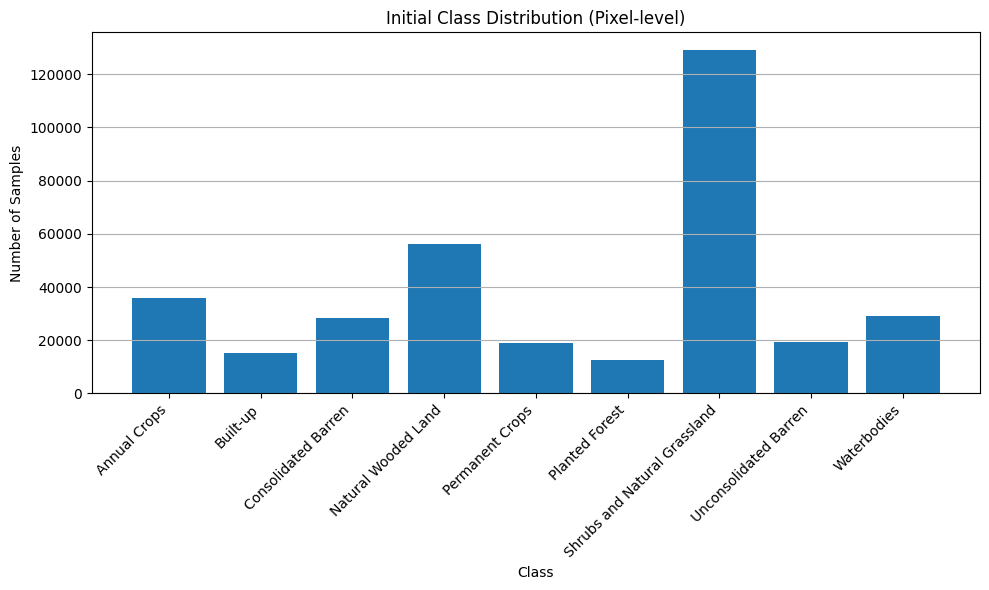

In [189]:
# Show initial class distribution at pixel-level
plot_class_distribution(samples_df['Label'].values, label_encoder.classes_, "Initial Class Distribution (Pixel-level)")

#### Stratified Split

In [190]:
# Image-level splitting before PCA to avoid data leakage
# We have pixel-level data with Sample_num and Label_Encoded.
unique_samples = samples_df[['Sample_num', 'Label_Encoded']].drop_duplicates()
train_samples, test_samples = stratified_image_level_split(unique_samples['Sample_num'].values,
                                                           unique_samples['Label_Encoded'].values,
                                                           test_size=0.2)

# Ridding warnings
train_df = samples_df[samples_df['Sample_num'].isin(train_samples)].copy()
test_df = samples_df[samples_df['Sample_num'].isin(test_samples)].copy()

#### Oversampling

In [191]:
# These are taken from above as well as verifying from actually looking them up
# NOTE: I am not oversampling Built-up or Waterbodies cause they are both really easy to identify shown by stats
oversample_images = {
    'Consolidated Barren': [2051, 21902, 2067, 9620, 2070, 10781, 7080, 10790, 20392, 7081, 7082, 7083, 7084, 7085, 9390, 7983, 9391, 22192, 7092, 7093, 7094, 9398, 7100, 7102, 7103, 20417, 7106, 8005, 21061, 2375, 22982, 24262, 4556, 8018, 8404, 8405, 22872, 4698, 9574, 9576, 9066, 8304, 8305, 8306, 7416, 8185, 8186, 8187, 5374, 4859],
    # 'Natural Grassland': [7424, 5634, 27138, 7947, 7692, 25228, 7701, 3991, 6009, 7708, 7711, 2848, 6052, 11812, 5414, 9510, 6952, 24997, 6827, 5936, 6192, 7984, 10801, 6973, 7742, 5063, 8520, 5065, 6602, 7881, 7118, 11087, 4822, 5594, 11103, 9442, 7011, 7652, 6757, 7013, 7656, 3435, 3437, 3565, 26095, 26353, 8825, 28026, 4731, 5629],
    'Unconsolidated Barren': [1, 2, 10883, 20610, 21639, 11, 20758, 26, 11682, 11683, 11684, 11685, 21671, 1065, 8235, 20013, 7342, 26416, 20026, 8507, 20034, 20676, 8141, 213, 20056, 10714, 10715, 10716, 10717, 10718, 10719, 10720, 10721, 10722, 10723, 10724, 10725, 10726, 10727, 20839, 27751, 20591, 11633, 11634, 11635, 7412, 20084, 20087, 22234, 20090],
    'Planted Forest': [7303, 5899, 5771, 8460, 5389, 5396, 5653, 5403, 5919, 8226, 8227, 2853, 5931, 5421, 7982, 5422, 6318, 5684, 5686, 5687, 5944, 5945, 6328, 6331, 6460, 5949, 5950, 6334, 5579, 5707, 5710, 5711, 6352, 5713, 5586, 5587, 5968, 5464, 5977, 5473, 5477, 5481, 5611, 5613, 5487, 5999, 6000, 6386, 6387, 6005],
    'Permanent Crops': [24067, 27268, 22533, 2829, 3983, 23444, 24084, 21782, 26263, 24856, 27163, 6044, 27547, 21022, 6046, 25249, 23715, 5028, 23849, 23724, 8495, 8496, 8497, 5042, 24115, 5043, 23608, 25789, 23623, 21964, 27597, 23252, 8406, 8407, 21209, 21983, 26336, 21985, 24930, 24041, 20971, 4855, 24178, 27251, 24950, 26871, 27643, 3708, 23166, 5887],
    'Annual Crops': [1538, 3331, 4, 3205, 2950, 7, 3078, 4739, 266, 4998, 1429, 8471, 3992, 7835, 2204, 5408, 2980, 4009, 3120, 1585, 3248, 1588, 2872, 5563, 3516, 1470, 8386, 4931, 1092, 1604, 2885, 10438, 1224, 5453, 8527, 1619, 3795, 3798, 1629, 3294, 2402, 1507, 3044, 2407, 4840, 1645, 3187, 4854, 3831, 3833],
}
# Modifies train_df in-place returns new df.
train_df = oversample_to_target_size(train_df, oversample_images, percentage=3)


Processing class 'Unconsolidated Barren':
Current size: 15644, Target size: 15644, Samples needed: 0

Processing class 'Consolidated Barren':
Current size: 22952, Target size: 22952, Samples needed: 0

Processing class 'Annual Crops':
Current size: 28382, Target size: 28382, Samples needed: 0

Processing class 'Shrubs and Natural Grassland':
Current size: 104351, Target size: 104351, Samples needed: 0

Processing class 'Natural Wooded Land':
Current size: 46310, Target size: 46310, Samples needed: 0

Processing class 'Permanent Crops':
Current size: 15853, Target size: 15853, Samples needed: 0

Processing class 'Built-up':
Current size: 12137, Target size: 12137, Samples needed: 0

Processing class 'Waterbodies':
Current size: 23579, Target size: 23579, Samples needed: 0

Processing class 'Planted Forest':
Current size: 10106, Target size: 10106, Samples needed: 0

Final class distributions after oversampling:
Class 'Consolidated Barren' oversampled to target size 22952.
Class 'Uncons

In [192]:
# Define target_size_per_class for augmentation
# Get largest class size post-oversampling (Obviously shrubs lol)
largest_class_size = (train_df['Label'] == 'Shrubs and Natural Grassland').sum()
target_size_per_class = {
    class_label: max(
        len(train_df[train_df['Label'] == class_label]),
        int(largest_class_size * (3 / 100.0))
    )
    for class_label in oversample_images.keys()
}

#### Apply Augmentation

In [193]:
train_df = augment_data(
    train_df,
    oversample_images,
    target_size_per_class,
    frequency_cols
)

# Shuffle the augmented training data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)


Augmenting class 'Consolidated Barren':
Current total size: 22952, Target size: 22952, Samples needed: 0

Augmenting class 'Unconsolidated Barren':
Current total size: 15644, Target size: 15644, Samples needed: 0

Augmenting class 'Planted Forest':
Current total size: 10106, Target size: 10106, Samples needed: 0

Augmenting class 'Permanent Crops':
Current total size: 15853, Target size: 15853, Samples needed: 0

Augmenting class 'Annual Crops':
Current total size: 28382, Target size: 28382, Samples needed: 0


#### Apply PCA & reconstruct Images from PCA DataFrames

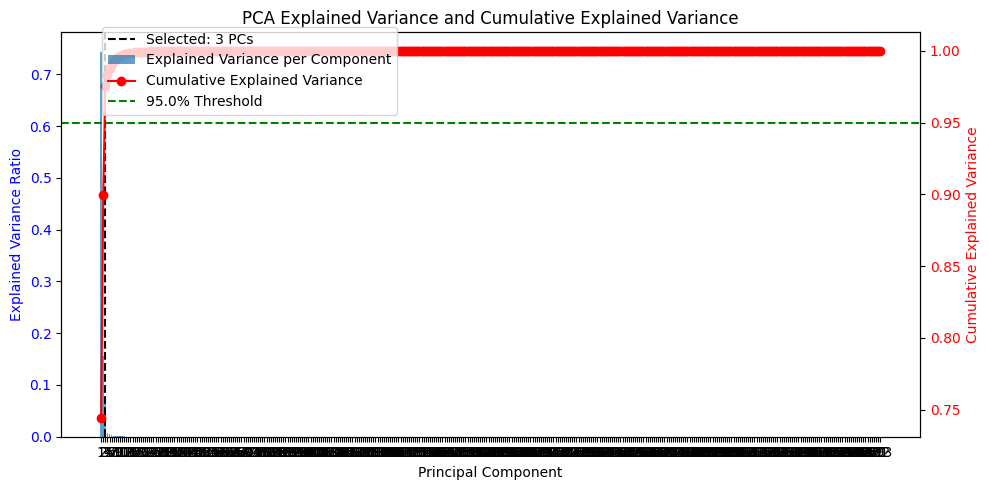


PCA completed with 3 components.
Total explained variance: 97.53%
Selected Principal Components: ['PC1', 'PC2', 'PC3']


In [194]:
# Apply PCA on pixel-level data (training only), then transform test
train_pca_df, test_pca_df, pca = apply_pca_pixel_level(train_df, test_df, frequency_cols)

# Determine available PCs
available_pcs = [c for c in train_pca_df.columns if c.startswith('PC')]

# Using ALL selected_pcs = available_pcs (Jsut trying it out...)
selected_pcs = available_pcs
print("Selected Principal Components:", selected_pcs)

In [195]:
# Reconstruct images from PCA DataFrames
X_train_pca_images, y_train_labels, train_image_sample_nums = reshape_to_images_using_img_pos(train_pca_df, selected_pcs=selected_pcs)
X_test_pca_images, y_test_labels, test_image_sample_nums = reshape_to_images_using_img_pos(test_pca_df, selected_pcs=selected_pcs)

Created 2322 images from PCA components ['PC1', 'PC2', 'PC3'].
Created 558 images from PCA components ['PC1', 'PC2', 'PC3'].


#### Filter categories with < 50 images

In [196]:
# Combine train and test sets before filtering infrequent classes
X_all_pca_images = X_train_pca_images + X_test_pca_images
y_all_labels = np.concatenate([y_train_labels, y_test_labels])
all_image_sample_nums = np.concatenate([train_image_sample_nums, test_image_sample_nums])

In [197]:
# Remove infrequent classes at the image level
X_all_pca_images, y_all_labels, all_image_sample_nums = remove_infrequent_image_labels(
    X_all_pca_images, y_all_labels, all_image_sample_nums, label_encoder, min_frequency=50
)

Classes retained (≥ 50 images): ['Annual Crops' 'Built-up' 'Consolidated Barren' 'Natural Wooded Land'
 'Permanent Crops' 'Planted Forest' 'Shrubs and Natural Grassland'
 'Unconsolidated Barren' 'Waterbodies']
Original image count: 2880
Filtered image count: 2880


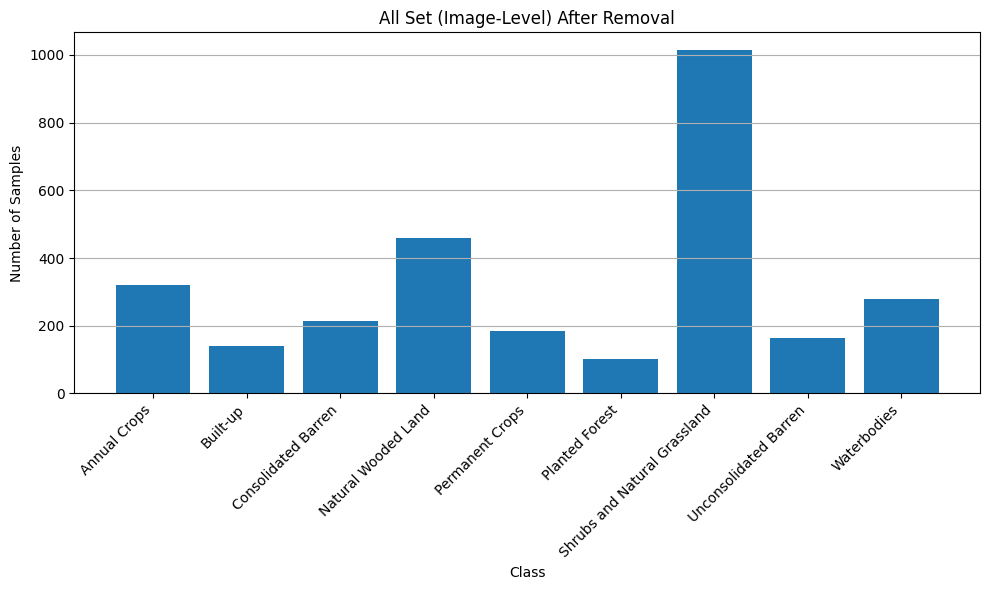

In [198]:
# Check distribution after removal
plot_class_distribution(y_all_labels, label_encoder.classes_, "All Set (Image-Level) After Removal")

#### Final Split at Image Level and Resize to (10,10)

In [199]:
# Now split & resize data into train/test sets, ensuring distinct Sample_nums
X_train, X_test, y_train, y_test = split_data_by_samples(
    X_all_pca_images, y_all_labels, all_image_sample_nums,
    train_samples, test_samples
)

Training set: 2322 images
Testing set: 558 images
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 10) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 10) to (10, 10)
Resizing image from (10, 11) to (10, 10)
Resizing image from (12, 11) to (10, 10)
Resizing image from (10, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (10, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 12) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (12, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 10) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 12) to (10, 10)
Resizing image from (11, 10) to (10, 10)
Resizin

In [200]:
# Verify shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
assert X_train.shape[1:] == (10, 10, len(selected_pcs)), f"Invalid X_train shape: {X_train.shape}"
if X_test.shape[0] > 0:
    assert X_test.shape[1:] == (10, 10, len(selected_pcs)), f"Invalid X_test shape: {X_test.shape}"

X_train shape: (2322, 10, 10, 3)
X_test shape: (558, 10, 10, 3)


In [201]:
# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

#### Get Class Weights


In [205]:
class_weights = get_class_weights(y_train)


Class Weights:
Planted Forest         Weight: 3.185185185185185
Built-up               Weight: 2.3454545454545452
Unconsolidated Barren  Weight: 1.9398496240601504
Permanent Crops        Weight: 1.6973684210526316
Consolidated Barren    Weight: 1.4742857142857142
Waterbodies            Weight: 1.1517857142857142
Annual Crops           Weight: 1.0       
Natural Wooded Land    Weight: 0.688     
Shrubs and Natural Grassland Weight: 0.31695331695331697


### Micro CNN


---



In [263]:
# Get the CNN model and Train
micro_model = get_micro_cnn(X_train.shape[1:], num_classes, drop_rate=.2)

In [264]:
micro_model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_57 (Conv2D)                   │ (None, 10, 10, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 5, 5, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 2, 2, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_17 (Flatten)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_48 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_49 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 297,737 (1.14 MB)

 Trainable params: 297,737 (1.14 MB)

 Non-trainable params: 0 (0.00 B)

#### Train without weights

In [ ]:
micro_history = train_model(micro_model, X_train, y_train_cat, X_test, y_test_cat,
                            epochs=100, batch_size=32, checkpoint_path=microcnn_checkpoint_path)

Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1362 - loss: 3.6560
Epoch 1: val_accuracy improved from -inf to 0.34451, saving model to /content/drive/My Drive/.School/Capstone/Checkpoints/microcnn_best.weights.h5
71/71 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.1370 - loss: 3.6452 - val_accuracy: 0.3445 - val_loss: 1.8416 - learning_rate: 1.0000e-04
Epoch 2/100
58/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4198 - loss: 1.6359
Epoch 2: val_accuracy improved from 0.34451 to 0.55866, saving model to /content/drive/My Drive/.School/Capstone/Checkpoints/microcnn_best.weights.h5
71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.4313 - loss: 1.6154 - val_accuracy: 0.5587 - val_loss: 1.3631 - learning_rate: 1.0000e-04
Epoch 3/100
59/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5220 - loss: 1.3400
Epoch 3: val_accuracy improved from 0.55866 to 0.57728, saving model to /content/drive/My Drive/.School/Capstone/Checkpoints/microcnn_best.weights.h5
71/71 ━━━━

#### Train Using Class Weights

In [ ]:
# micro_history = train_model_with_class_weights(
#     micro_model,
#     X_train,
#     y_train_cat,
#     X_test,
#     y_test_cat,
#     class_weights=class_weights,
#     epochs=100,
#     batch_size=32
# )

In [230]:
# Get the testing accuracy
micro_test_acc = evaluate_model(micro_model, X_test, y_test_cat)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4363 - loss: 1.3772 
Test Accuracy: 0.4964


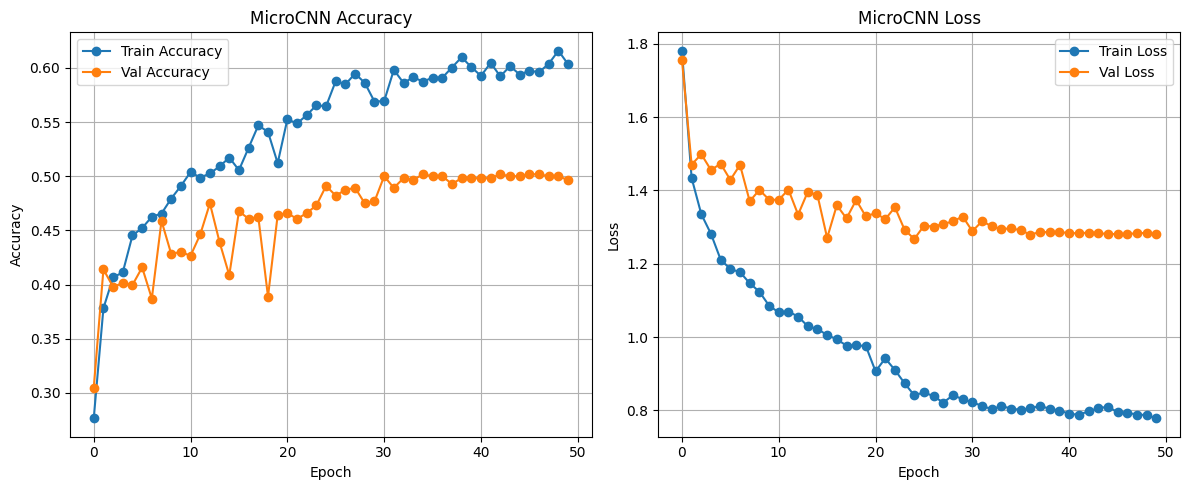

In [231]:
# Plotting the training curves
plot_training_curves(micro_history, "MicroCNN")

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


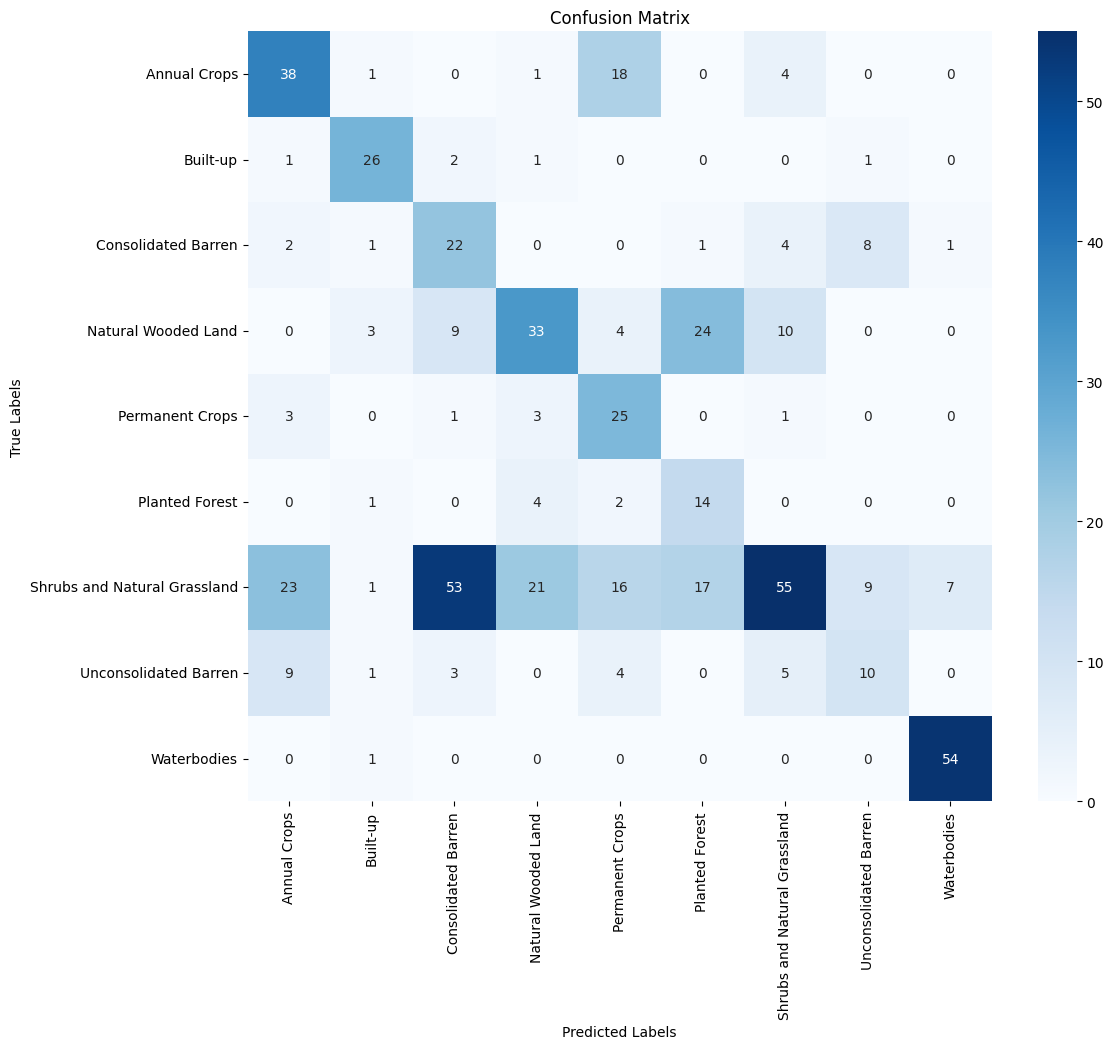

In [232]:
# Get the predictions and create a CM
y_true_labels, y_pred_labels, _, _ = get_predictions(micro_model, X_test, y_test_cat, label_encoder)
plot_confusion_matrix(y_true_labels, y_pred_labels, label_encoder)

In [233]:
print("Classification Report (MicroCNN):")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))

Classification Report (MicroCNN):
                              precision    recall  f1-score   support

                Annual Crops       0.50      0.61      0.55        62
                    Built-up       0.74      0.84      0.79        31
         Consolidated Barren       0.24      0.56      0.34        39
         Natural Wooded Land       0.52      0.40      0.45        83
             Permanent Crops       0.36      0.76      0.49        33
              Planted Forest       0.25      0.67      0.36        21
Shrubs and Natural Grassland       0.70      0.27      0.39       202
       Unconsolidated Barren       0.36      0.31      0.33        32
                 Waterbodies       0.87      0.98      0.92        55

                    accuracy                           0.50       558
                   macro avg       0.51      0.60      0.51       558
                weighted avg       0.58      0.50      0.49       558



### MacroCNN


---



In [ ]:
# Train MacroCNN
macro_model = get_macro_cnn(X_train.shape[1:], len(label_encoder.classes_))
macro_history = train_model(macro_model, X_train, y_train_cat, X_test, y_test_cat, epochs=50, batch_size=32, checkpoint_path=macrocnn_checkpoint_path)

Epoch 1/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2490 - loss: 2.0034
Epoch 1: val_accuracy improved from -inf to 0.52514, saving model to /content/drive/My Drive/.School/Capstone/Checkpoints/macrocnn_best.weights.h5
71/71 ━━━━━━━━━━━━━━━━━━━━ 13s 84ms/step - accuracy: 0.2502 - loss: 2.0018 - val_accuracy: 0.5251 - val_loss: 1.5642 - learning_rate: 1.0000e-04
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4780 - loss: 1.5938
Epoch 2: val_accuracy improved from 0.52514 to 0.57542, saving model to /content/drive/My Drive/.School/Capstone/Checkpoints/macrocnn_best.weights.h5
71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4781 - loss: 1.5931 - val_accuracy: 0.5754 - val_loss: 1.3024 - learning_rate: 1.0000e-04
Epoch 3/50
60/71 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5248 - loss: 1.3854
Epoch 3: val_accuracy improved from 0.57542 to 0.63128, saving model to /content/drive/My Drive/.School/Capstone/Checkpoints/macrocnn_best.weights.h5
71/71 ━━━━━━

In [ ]:
macro_test_acc = evaluate_model(macro_model, X_test, y_test_cat)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6632 - loss: 0.8667
Test Accuracy: 0.6387


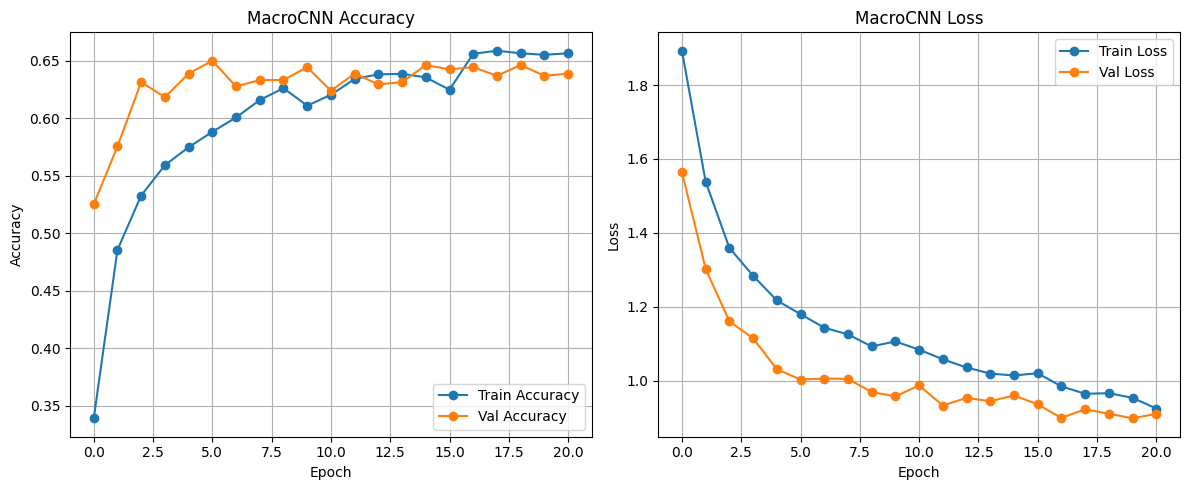

In [ ]:
plot_training_curves(macro_history, "MacroCNN")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


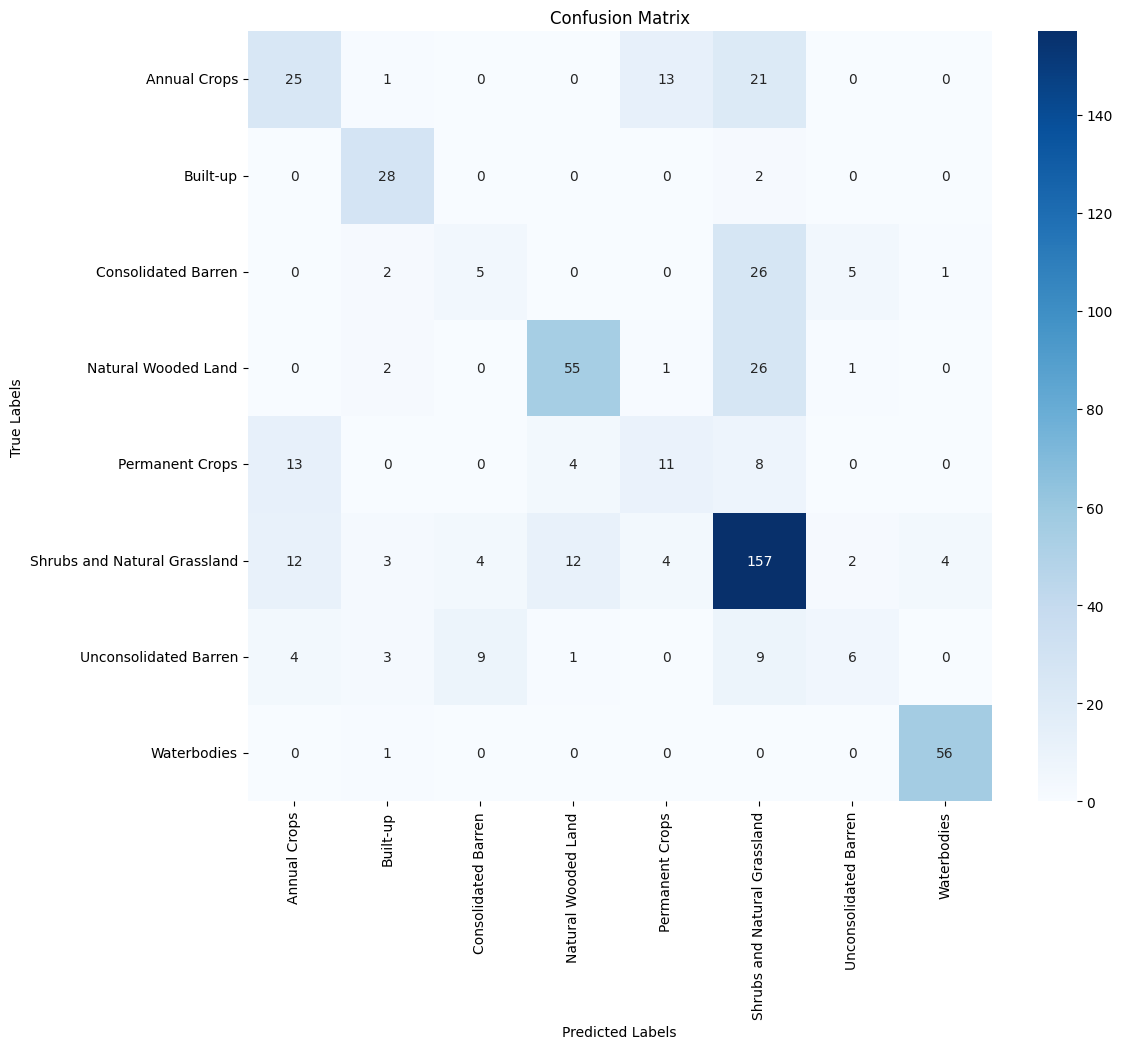

In [ ]:
y_true_labels_macro, y_pred_labels_macro, _, _ = get_predictions(macro_model, X_test, y_test_cat, label_encoder)
plot_confusion_matrix(y_true_labels_macro, y_pred_labels_macro, label_encoder)

In [ ]:
print("Classification Report (MacroCNN):")
print(classification_report(y_true_labels_macro, y_pred_labels_macro, target_names=label_encoder.classes_))

Classification Report (MacroCNN):
                              precision    recall  f1-score   support

                Annual Crops       0.46      0.42      0.44        60
                    Built-up       0.70      0.93      0.80        30
         Consolidated Barren       0.28      0.13      0.18        39
         Natural Wooded Land       0.76      0.65      0.70        85
             Permanent Crops       0.38      0.31      0.34        36
Shrubs and Natural Grassland       0.63      0.79      0.70       198
       Unconsolidated Barren       0.43      0.19      0.26        32
                 Waterbodies       0.92      0.98      0.95        57

                    accuracy                           0.64       537
                   macro avg       0.57      0.55      0.55       537
                weighted avg       0.61      0.64      0.62       537



### RGB CNN

RGB CNN (No PCA, uses RGB-like bands)
 - Idea is that data is an array of shape (num_images,10,10,3)
 extracted from three specific frequency bands chosen.
---



Created 2880 RGB images using bands ['frq21', 'frq35', 'frq57'].


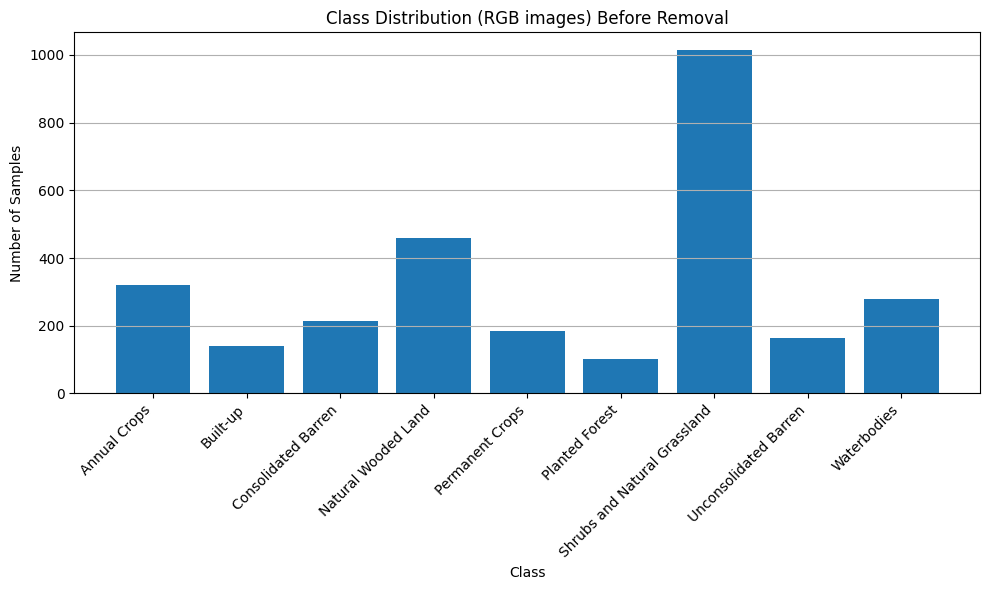

Classes retained (≥ 50 images): ['Annual Crops' 'Built-up' 'Consolidated Barren' 'Natural Wooded Land'
 'Permanent Crops' 'Planted Forest' 'Shrubs and Natural Grassland'
 'Unconsolidated Barren' 'Waterbodies']
Original image count: 2880
Filtered image count: 2880
Training set: 2300 images
Testing set: 580 images
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 10) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 10) to (10, 10)
Resizing image from (10, 11) to (10, 10)
Resizing image from (12, 11) to (10, 10)
Resizing image from (10, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (10, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 12) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 11) to (10, 10)
Resizing image from (11, 11) t

In [266]:
### RGB CNN (No PCA, uses RGB-like bands)
# Extracted from three specific frequency bands: 'frq21', 'frq35', 'frq57'

# Step 1: Create RGB Images
rgb_bands = ['frq21', 'frq35', 'frq57']
rgb_images, rgb_labels, rgb_sample_nums = create_rgb_images(samples_df, rgb_bands)

# Step 2: Show class distribution at image-level before removal
plot_class_distribution(rgb_labels, label_encoder.classes_, "Class Distribution (RGB images) Before Removal")

# Step 3: Combine Train and Test Samples Before Filtering Infrequent Classes
# Ensure uniform filtering process across train and test sets
rgb_images_combined, rgb_labels_combined, rgb_sample_nums_combined = remove_infrequent_image_labels(
    rgb_images, rgb_labels, rgb_sample_nums, label_encoder, min_frequency=50
)

# Step 4: Stratified Split After Filtering
train_samples_rgb, test_samples_rgb = stratified_image_level_split(
    rgb_sample_nums_combined, rgb_labels_combined, test_size=0.2
)

# Step 5: Split into Train/Test Sets and Resize Images
X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = split_data_by_samples(
    rgb_images_combined, rgb_labels_combined, rgb_sample_nums_combined,
    train_samples_rgb, test_samples_rgb
)

X_train_rgb shape: (2300, 10, 10, 3)
X_test_rgb shape: (580, 10, 10, 3)


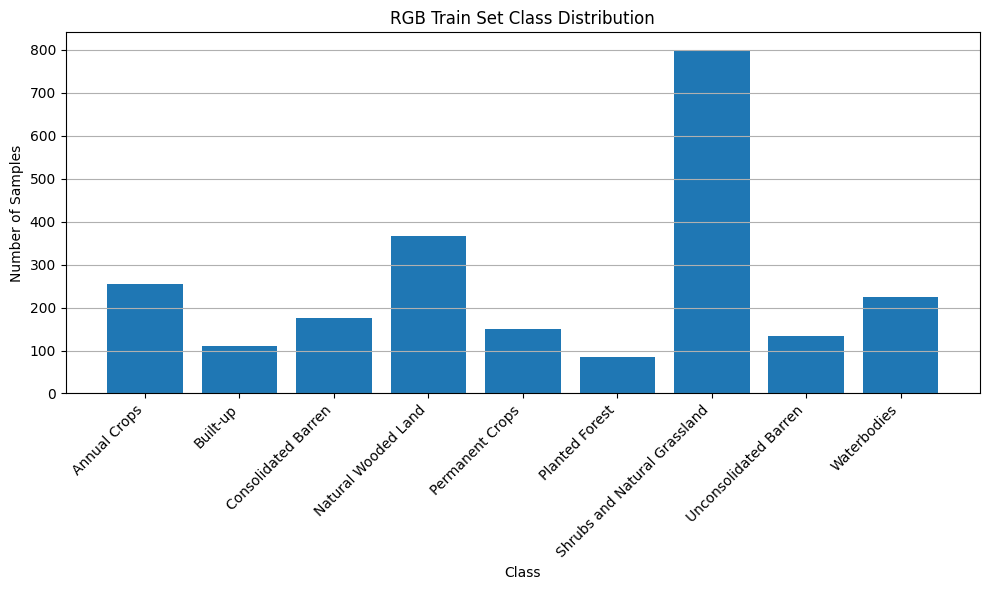

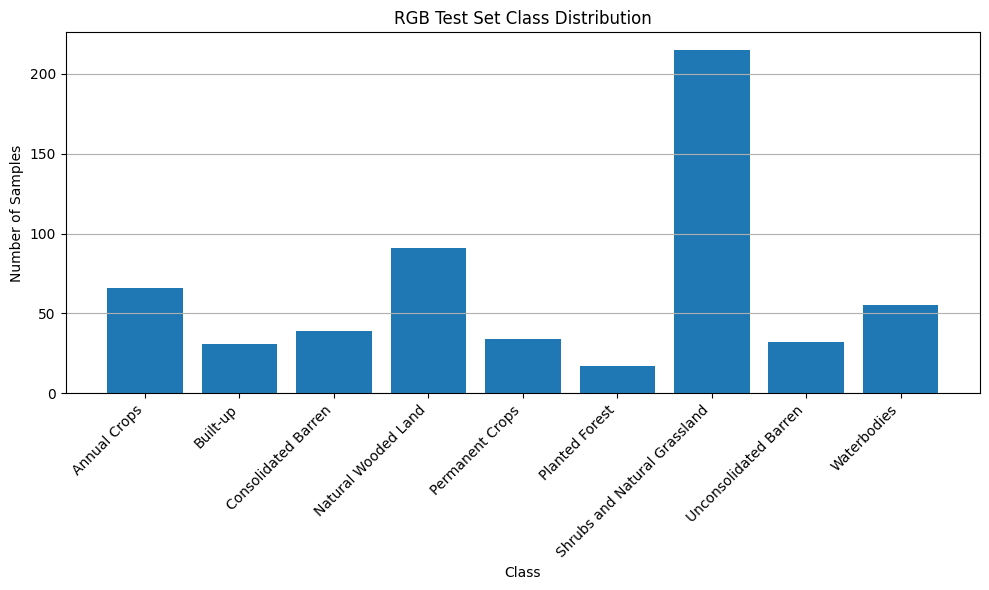

In [267]:
# Step 6: Verify Shapes and Resize Check
assert X_train_rgb.shape[1:] == (10, 10, 3), f"Invalid X_train shape: {X_train_rgb.shape}"
assert X_test_rgb.shape[1:] == (10, 10, 3), f"Invalid X_test shape: {X_test_rgb.shape}"

print("X_train_rgb shape:", X_train_rgb.shape)
print("X_test_rgb shape:", X_test_rgb.shape)

# Step 7: Show Class Distribution in Train/Test Sets
plot_class_distribution(y_train_rgb, label_encoder.classes_, "RGB Train Set Class Distribution")
plot_class_distribution(y_test_rgb, label_encoder.classes_, "RGB Test Set Class Distribution")

# Step 8: Convert Labels to Categorical
y_train_rgb_cat = to_categorical(y_train_rgb, num_classes=len(label_encoder.classes_))
y_test_rgb_cat = to_categorical(y_test_rgb, num_classes=len(label_encoder.classes_))

In [268]:
# Step 10: Train and Evaluate the RGB CNN
# Step 9: Get the RGB CNN Model
rgb_model = get_rgb_cnn(X_train_rgb.shape[1:], len(label_encoder.classes_))

rgb_history = train_model(rgb_model, X_train_rgb, y_train_rgb_cat, X_test_rgb, y_test_rgb_cat, epochs=50,
                            batch_size=32, checkpoint_path=rgbcnn_checkpoint_path)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2508 - loss: 2.2433
Epoch 1: val_accuracy improved from -inf to 0.37069, saving model to /content/drive/My Drive/.School/Capstone/Checkpoints/rgbcnn_best.weights.h5
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.2523 - loss: 2.2389 - val_accuracy: 0.3707 - val_loss: 2.0367 - learning_rate: 5.0000e-04
Epoch 2/50
49/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4448 - loss: 1.6093
Epoch 2: val_accuracy did not improve from 0.37069
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4500 - loss: 1.5898 - val_accuracy: 0.3707 - val_loss: 1.9289 - learning_rate: 5.0000e-04
Epoch 3/50
53/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4960 - loss: 1.4037
Epoch 3: val_accuracy did not improve from 0.37069
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4935 - loss: 1.4118 - val_accuracy: 0.3707 - val_loss: 1.8544 - learning_rate: 5.0000e-04
Epoch 4/50
71/72 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5078

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5982 - loss: 1.1366 
Test Accuracy: 0.5983
RGB CNN Test Accuracy: 0.5983


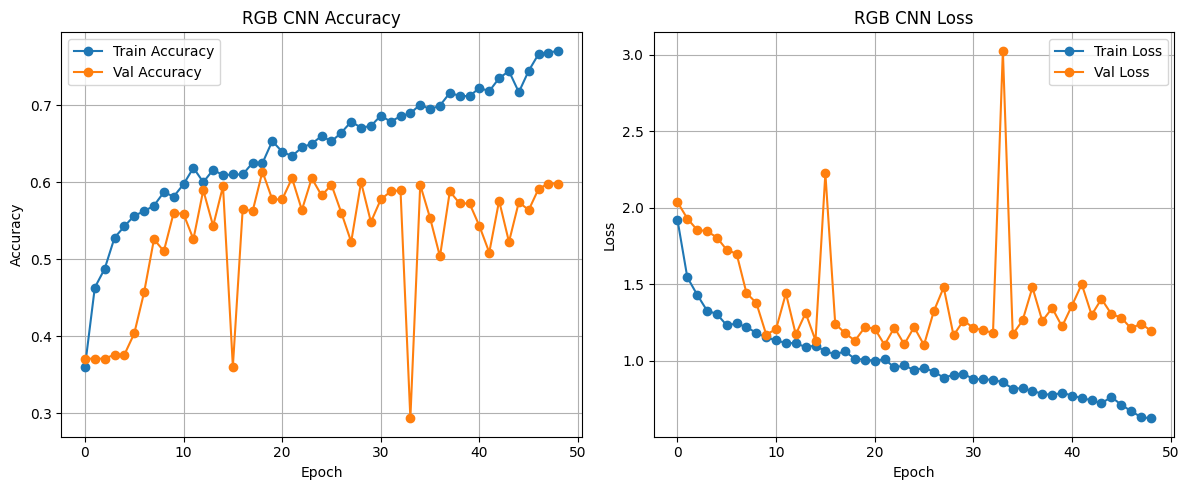

In [269]:
# Step 11: Evaluate Model Accuracy
rgb_test_accuracy = evaluate_model(rgb_model, X_test_rgb, y_test_rgb_cat)
print(f"RGB CNN Test Accuracy: {rgb_test_accuracy:.4f}")

# Step 12: Plot Training Curves
plot_training_curves(rgb_history, "RGB CNN")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


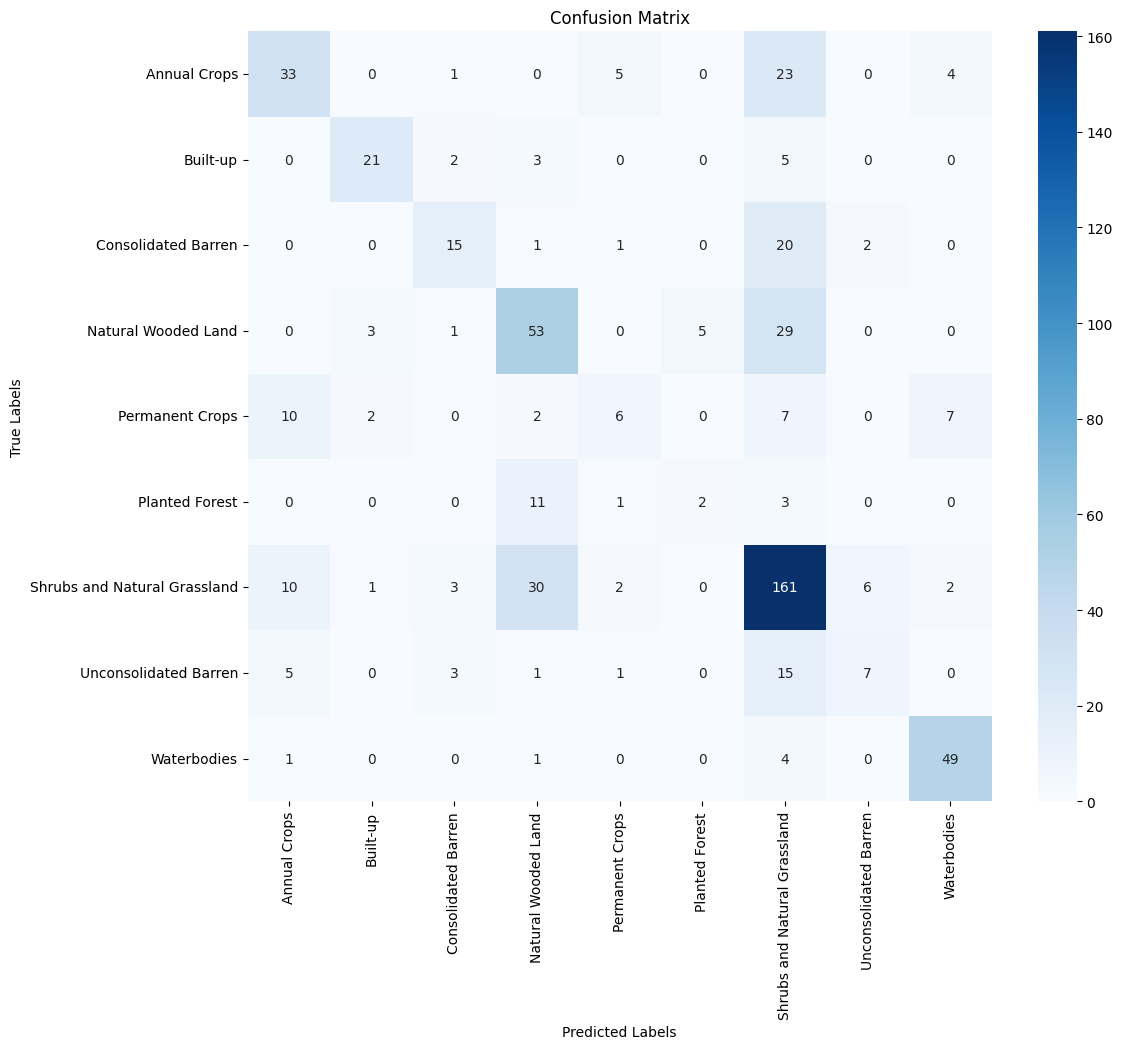

Classification Report (RGB CNN):
                              precision    recall  f1-score   support

                Annual Crops       0.56      0.50      0.53        66
                    Built-up       0.78      0.68      0.72        31
         Consolidated Barren       0.60      0.38      0.47        39
         Natural Wooded Land       0.52      0.58      0.55        91
             Permanent Crops       0.38      0.18      0.24        34
              Planted Forest       0.29      0.12      0.17        17
Shrubs and Natural Grassland       0.60      0.75      0.67       215
       Unconsolidated Barren       0.47      0.22      0.30        32
                 Waterbodies       0.79      0.89      0.84        55

                    accuracy                           0.60       580
                   macro avg       0.55      0.48      0.50       580
                weighted avg       0.58      0.60      0.58       580



In [270]:
# Step 13: Generate Predictions and Confusion Matrix
y_true_labels_rgb, y_pred_labels_rgb, _, _ = get_predictions(
    rgb_model, X_test_rgb, y_test_rgb_cat, label_encoder
)
plot_confusion_matrix(y_true_labels_rgb, y_pred_labels_rgb, label_encoder)

# Step 14: Print Classification Report
print("Classification Report (RGB CNN):")
print(classification_report(y_true_labels_rgb, y_pred_labels_rgb, target_names=label_encoder.classes_))